In [1]:
# ============================================
# 1. IMPORTS Y CONFIGURACIÓN
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

# HDBSCAN
try:
    import hdbscan
    HDBSCAN_AVAILABLE = True
    print("✅ HDBSCAN disponible")
except ImportError:
    HDBSCAN_AVAILABLE = False
    print("⚠️ HDBSCAN no instalado. Ejecutar: pip install hdbscan")

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Librerías cargadas correctamente")

✅ HDBSCAN disponible
✅ Librerías cargadas correctamente


## 1. Carga y Preparación de Datos

In [2]:
# ============================================
# CARGAR FEATURES MATRIX
# ============================================
df_features = pd.read_csv('../data/features_matrix.csv', index_col='ticker')

print(f"📊 Shape del dataset: {df_features.shape}")
print(f"📈 Número de activos: {df_features.shape[0]}")
print(f"📋 Número de features: {df_features.shape[1]}")
print("\n🔍 Primeras filas:")
df_features.head()

📊 Shape del dataset: (468, 20)
📈 Número de activos: 468
📋 Número de features: 20

🔍 Primeras filas:


,return_total,return_annualized,return_mean_daily,volatility_annual,downside_dev_annual,max_drawdown,var_95,cvar_95,sharpe_ratio,sortino_ratio,calmar_ratio,beta,alpha_annual,r_squared,correlation_spy,skewness,kurtosis,positive_return_ratio,gain_loss_ratio,vol_of_vol
ticker,,,,,,,,,,,,,,,,,,,,
A,0.171864,0.054633,0.000368,0.282317,0.279555,-0.435687,-0.029414,-0.037721,0.151784,0.153283,0.125395,1.048419,-0.012664,0.430402,0.656050,0.239581,2.063034,0.515957,0.986270,0.005313
AAL,-0.091870,-0.031805,0.000308,0.469775,0.449370,-0.577072,-0.044331,-0.062014,0.058819,0.061490,-0.055115,1.407044,-0.063976,0.279971,0.529123,0.193564,1.247544,0.484043,1.076244,0.008824
AAP,-0.612114,-0.272134,-0.000917,0.397305,0.463392,-0.800546,-0.035611,-0.061724,-0.707455,-0.606561,-0.339935,0.911450,-0.322806,0.164246,0.405273,-4.070076,52.146478,0.496011,0.907258,0.012008
AAPL,0.487752,0.142527,0.000681,0.277969,0.275832,-0.313115,-0.029794,-0.038538,0.437804,0.441195,0.455193,1.263736,0.044510,0.645059,0.803155,0.102541,1.734805,0.519947,1.018775,0.005781
ABBV,0.470164,0.137979,0.000599,0.208412,0.229641,-0.242627,-0.019269,-0.032427,0.484830,0.440012,0.568690,0.361027,0.114710,0.093650,0.306023,-0.951209,4.925630,0.549202,0.928613,0.003738


In [3]:
# ============================================
# INSPECCIÓN DE FEATURES
# ============================================
print("📋 Features disponibles:")
print("="*50)
for i, col in enumerate(df_features.columns, 1):
    print(f"{i:2d}. {col}")

print("\n📊 Estadísticas descriptivas:")
df_features.describe().T

📋 Features disponibles:
 1. return_total
 2. return_annualized
 3. return_mean_daily
 4. volatility_annual
 5. downside_dev_annual
 6. max_drawdown
 7. var_95
 8. cvar_95
 9. sharpe_ratio
10. sortino_ratio
11. calmar_ratio
12. beta
13. alpha_annual
14. r_squared
15. correlation_spy
16. skewness
17. kurtosis
18. positive_return_ratio
19. gain_loss_ratio
20. vol_of_vol

📊 Estadísticas descriptivas:


,count,mean,std,min,25%,50%,75%,max
return_total,468.0,0.256879,0.509233,-0.988230,-0.036569,0.185576,0.449552,2.777269
return_annualized,468.0,0.060010,0.148424,-0.774608,-0.012418,0.058755,0.132603,0.561655
return_mean_daily,468.0,0.000432,0.001081,-0.003092,0.000131,0.000367,0.000669,0.020444
volatility_annual,468.0,0.301763,0.202726,0.021851,0.231515,0.274280,0.341856,4.112265
downside_dev_annual,468.0,0.298650,0.130843,0.021479,0.235161,0.277135,0.342022,2.226717
max_drawdown,468.0,-0.406273,0.157360,-0.999994,-0.491099,-0.379430,-0.289207,-0.068171
var_95,468.0,-0.028662,0.010560,-0.136199,-0.032774,-0.026626,-0.022262,-0.002205
cvar_95,468.0,-0.041451,0.019819,-0.359535,-0.047209,-0.038573,-0.032328,-0.003246
sharpe_ratio,468.0,0.148342,0.461975,-3.069607,-0.068490,0.167821,0.417299,1.415592
sortino_ratio,468.0,0.154077,0.476798,-3.122794,-0.069046,0.172873,0.412958,2.291198


In [4]:
# ============================================
# VERIFICAR VALORES NULOS E INFINITOS
# ============================================
print("🔍 Verificación de calidad de datos:")
print("="*50)

# Valores nulos
null_counts = df_features.isnull().sum()
if null_counts.sum() > 0:
    print("\n⚠️ Valores nulos encontrados:")
    print(null_counts[null_counts > 0])
else:
    print("✅ No hay valores nulos")

# Valores infinitos
inf_counts = np.isinf(df_features.select_dtypes(include=[np.number])).sum()
if inf_counts.sum() > 0:
    print("\n⚠️ Valores infinitos encontrados:")
    print(inf_counts[inf_counts > 0])
else:
    print("✅ No hay valores infinitos")

🔍 Verificación de calidad de datos:
✅ No hay valores nulos
✅ No hay valores infinitos


In [5]:
# ============================================
# SELECCIÓN DE FEATURES PARA CLUSTERING
# ============================================
# Se seleccionan 10 features que cubren 4 dimensiones fundamentales del análisis
# de riesgo-retorno en finanzas. Esta selección busca:
#   - Evitar redundancia (no incluir features altamente correlacionadas)
#   - Cobertura completa de riesgo sistemático y específico
#   - Métricas relevantes para gestión de portafolios
#
# ┌─────────────────────────────────────────────────────────────────────────────┐
# │ DIMENSIÓN 1: RETORNO (1 feature)                                            │
# ├─────────────────────────────────────────────────────────────────────────────┤
# │ • return_annualized: Rentabilidad esperada anualizada del activo            │
# │                                                                             │
# │ DIMENSIÓN 2: RIESGO / VOLATILIDAD (4 features)                              │
# ├─────────────────────────────────────────────────────────────────────────────┤
# │ • volatility_annual: Desviación estándar anualizada (riesgo total)          │
# │ • max_drawdown:      Peor caída desde un máximo histórico (riesgo de cola)  │
# │ • var_95:            Value at Risk - Pérdida máxima al 95% de confianza     │
# │ • cvar_95:           Expected Shortfall - Pérdida promedio cuando VaR falla │
# │                                                                             │
# │ DIMENSIÓN 3: RETORNO AJUSTADO POR RIESGO (2 features)                       │
# ├─────────────────────────────────────────────────────────────────────────────┤
# │ • sharpe_ratio:  Retorno excedente por unidad de riesgo total               │
# │                  Fórmula: (R - Rf) / σ                                      │
# │ • sortino_ratio: Retorno excedente por unidad de riesgo a la baja           │
# │                  Más relevante para inversores aversos a pérdidas           │
# │                                                                             │
# │ DIMENSIÓN 4: CARACTERÍSTICAS DE LA DISTRIBUCIÓN (3 features)                │
# ├─────────────────────────────────────────────────────────────────────────────┤
# │ • beta:     Sensibilidad al mercado (riesgo sistemático, no diversificable) │
# │             β > 1: más volátil que el mercado, β < 1: menos volátil         │
# │ • skewness: Asimetría de la distribución de retornos                        │
# │             Negativo: cola izquierda pesada (más pérdidas extremas)         │
# │ • kurtosis: Curtosis - frecuencia de eventos extremos (colas pesadas)       │
# │             > 3: leptocúrtica (más extremos que normal)                     │
# └─────────────────────────────────────────────────────────────────────────────┘

feature_cols = [
    'return_annualized',   # Retorno
    'volatility_annual',   # Riesgo
    'sharpe_ratio',        # Ajustado por riesgo
    'sortino_ratio',       # Ajustado por riesgo (downside)
    'max_drawdown',        # Riesgo de cola
    'var_95',              # Riesgo - Value at Risk
    'cvar_95',             # Riesgo - Expected Shortfall
    'beta',                # Riesgo sistemático
    'skewness',            # Distribución - asimetría
    'kurtosis'             # Distribución - colas
]

print(f"🎯 Features seleccionadas para clustering: {len(feature_cols)}")
for col in feature_cols:
    print(f"   • {col}")

# Crear subset
df_cluster = df_features[feature_cols].copy()
print(f"\n📊 Shape del subset: {df_cluster.shape}")

🎯 Features seleccionadas para clustering: 10
   • return_annualized
   • volatility_annual
   • sharpe_ratio
   • sortino_ratio
   • max_drawdown
   • var_95
   • cvar_95
   • beta
   • skewness
   • kurtosis

📊 Shape del subset: (468, 10)


## 2. Normalización de Features

In [6]:
# ============================================
# LIMPIEZA DE DATOS
# ============================================
# Eliminar filas con NaN o infinitos
df_clean = df_cluster.replace([np.inf, -np.inf], np.nan).dropna()

print(f"📊 Activos antes de limpieza: {len(df_cluster)}")
print(f"📊 Activos después de limpieza: {len(df_clean)}")
print(f"🗑️ Activos eliminados: {len(df_cluster) - len(df_clean)}")

if len(df_cluster) - len(df_clean) > 0:
    removed = set(df_cluster.index) - set(df_clean.index)
    print(f"\n🔍 Tickers eliminados: {removed}")

📊 Activos antes de limpieza: 468
📊 Activos después de limpieza: 468
🗑️ Activos eliminados: 0


In [7]:
# ============================================
# NORMALIZACIÓN CON STANDARDSCALER
# ============================================
# ¿Por qué StandardScaler y no logaritmos?
# -----------------------------------------
# 1. Las features incluyen valores NEGATIVOS (sharpe, sortino, max_drawdown, 
#    VaR, CVaR, skewness) → log(x) no está definido para x ≤ 0
#
# 2. Las features ya son MÉTRICAS DERIVADAS (no precios crudos):
#    - Los retornos ya fueron calculados como log-returns en el preprocesamiento
#    - Volatilidad, Sharpe, etc. ya tienen distribuciones aproximadamente normales
#
# 3. StandardScaler (z-score) es IDEAL para clustering porque:
#    - K-Means usa distancia euclidiana → features con mayor varianza dominarían
#    - Iguala la contribución de cada feature al clustering
#    - Fórmula: z = (x - μ) / σ  →  media=0, std=1
# ============================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)

# Crear DataFrame normalizado para referencia
df_scaled = pd.DataFrame(X_scaled, index=df_clean.index, columns=feature_cols)

print("✅ Features normalizadas (media=0, std=1)")
print("\n📊 Verificación de normalización:")
print(f"   Media: {X_scaled.mean(axis=0).round(6)}")
print(f"   Std:   {X_scaled.std(axis=0).round(2)}")

df_scaled.head()

✅ Features normalizadas (media=0, std=1)

📊 Verificación de normalización:
   Media: [-0. -0.  0. -0.  0. -0.  0.  0.  0. -0.]
   Std:   [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


,return_annualized,volatility_annual,sharpe_ratio,sortino_ratio,max_drawdown,var_95,cvar_95,beta,skewness,kurtosis
ticker,,,,,,,,,,
A,-0.036262,-0.096026,0.007458,-0.001666,-0.187121,-0.071351,0.188406,0.329631,0.336759,-0.248149
AAL,-0.619257,0.829649,-0.193991,-0.194393,-1.086562,-1.485402,-1.038650,1.140031,0.286467,-0.310943
AAP,-2.240188,0.471790,-1.854460,-1.597013,-2.508225,-0.658756,-1.024011,0.020115,-4.373211,3.608393
AAPL,0.556554,-0.117498,0.627246,0.602824,0.592644,-0.107335,0.147167,0.816192,0.186990,-0.273423
ABBV,0.525879,-0.460969,0.729148,0.600340,1.041063,0.890400,0.455819,-1.223700,-0.964641,-0.027722


## 2.1 Detección de Outliers con DBSCAN

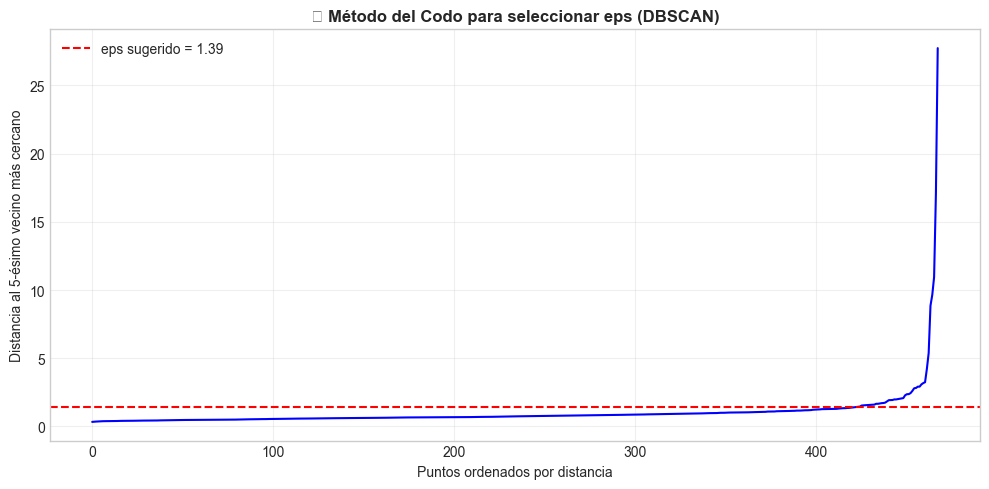

📊 eps sugerido (percentil 90): 1.39


In [8]:
# ============================================
# DETECCIÓN DE OUTLIERS CON DBSCAN
# ============================================
# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
# - No requiere especificar número de clusters
# - Identifica outliers como puntos que no pertenecen a ningún cluster (label = -1)
# - eps: radio máximo de vecindad
# - min_samples: mínimo de puntos para formar un cluster denso
# ============================================

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Método del codo para encontrar eps óptimo
# Calcular distancia al k-ésimo vecino más cercano
k = 5  # min_samples típico
neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)
distances = np.sort(distances[:, k-1])  # Distancia al k-ésimo vecino

# Visualizar para encontrar el "codo"
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(distances, 'b-', linewidth=1.5)
ax.set_xlabel('Puntos ordenados por distancia')
ax.set_ylabel(f'Distancia al {k}-ésimo vecino más cercano')
ax.set_title('🔍 Método del Codo para seleccionar eps (DBSCAN)', fontweight='bold')
ax.grid(True, alpha=0.3)

# Sugerir eps basado en el codo (percentil 90-95)
eps_suggested = np.percentile(distances, 90)
ax.axhline(y=eps_suggested, color='r', linestyle='--', label=f'eps sugerido = {eps_suggested:.2f}')
ax.legend()
plt.tight_layout()
plt.show()

print(f"📊 eps sugerido (percentil 90): {eps_suggested:.2f}")

In [9]:
# ============================================
# APLICAR DBSCAN PARA DETECTAR OUTLIERS
# ============================================
# Probar diferentes valores de eps
eps_values = [eps_suggested * 0.8, eps_suggested, eps_suggested * 1.2]

print("🔍 DETECCIÓN DE OUTLIERS CON DBSCAN")
print("="*60)

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    
    n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_outliers_db = (dbscan_labels == -1).sum()
    pct_outliers = 100 * n_outliers_db / len(dbscan_labels)
    
    print(f"\neps = {eps:.2f}:")
    print(f"   Clusters encontrados: {n_clusters_db}")
    print(f"   Outliers detectados:  {n_outliers_db} ({pct_outliers:.1f}%)")

# Usar eps sugerido para el análisis final
dbscan_final = DBSCAN(eps=eps_suggested, min_samples=5)
dbscan_outlier_labels = dbscan_final.fit_predict(X_scaled)

# Agregar columna de outliers al DataFrame
df_clean['is_outlier_dbscan'] = dbscan_outlier_labels == -1

print(f"\n✅ Usando eps = {eps_suggested:.2f} para detección de outliers")

🔍 DETECCIÓN DE OUTLIERS CON DBSCAN

eps = 1.11:
   Clusters encontrados: 2
   Outliers detectados:  57 (12.2%)

eps = 1.39:
   Clusters encontrados: 3
   Outliers detectados:  29 (6.2%)

eps = 1.67:
   Clusters encontrados: 2
   Outliers detectados:  20 (4.3%)

✅ Usando eps = 1.39 para detección de outliers


In [10]:
# ============================================
# ANÁLISIS DE OUTLIERS DETECTADOS
# ============================================
outliers_dbscan = df_clean[df_clean['is_outlier_dbscan']]
normal_points = df_clean[~df_clean['is_outlier_dbscan']]

print("🔴 OUTLIERS DETECTADOS POR DBSCAN")
print("="*60)
print(f"\nTotal de outliers: {len(outliers_dbscan)} de {len(df_clean)} ({100*len(outliers_dbscan)/len(df_clean):.1f}%)")

if len(outliers_dbscan) > 0:
    print("\n📋 Tickers identificados como outliers:")
    print(outliers_dbscan.index.tolist())
    
    print("\n📊 Comparación: Outliers vs Normal (promedio)")
    print("-"*60)
    comparison = pd.DataFrame({
        'Outliers': outliers_dbscan[feature_cols].mean(),
        'Normal': normal_points[feature_cols].mean(),
        'Diferencia %': ((outliers_dbscan[feature_cols].mean() - normal_points[feature_cols].mean()) 
                         / normal_points[feature_cols].mean().abs() * 100).round(1)
    })
    display(comparison)
else:
    print("\n✅ No se detectaron outliers con los parámetros actuales")

🔴 OUTLIERS DETECTADOS POR DBSCAN

Total de outliers: 29 de 468 (6.2%)

📋 Tickers identificados como outliers:
['AAP', 'ALGN', 'ARKK', 'BIIB', 'DVA', 'EPAM', 'ETSY', 'FIS', 'FTNT', 'GILD', 'GNRC', 'HCA', 'HIG', 'KWEB', 'LLY', 'LUMN', 'MCK', 'MPC', 'MTCH', 'NVDA', 'PAYC', 'RJF', 'SBNY', 'SEDG', 'SHY', 'UNG', 'VFC', 'VIXY', 'VXX']

📊 Comparación: Outliers vs Normal (promedio)
------------------------------------------------------------


,Outliers,Normal,Diferencia %
return_annualized,-0.088380,0.069812,-226.6
volatility_annual,0.577852,0.283525,103.8
sharpe_ratio,-0.072434,0.162927,-144.5
sortino_ratio,-0.021913,0.165703,-113.2
max_drawdown,-0.626787,-0.391706,-60.0
var_95,-0.044566,-0.027611,-61.4
cvar_95,-0.070379,-0.039540,-78.0
beta,0.918020,0.901526,1.8
skewness,0.678689,-0.117919,675.6
kurtosis,27.712932,3.804119,628.5


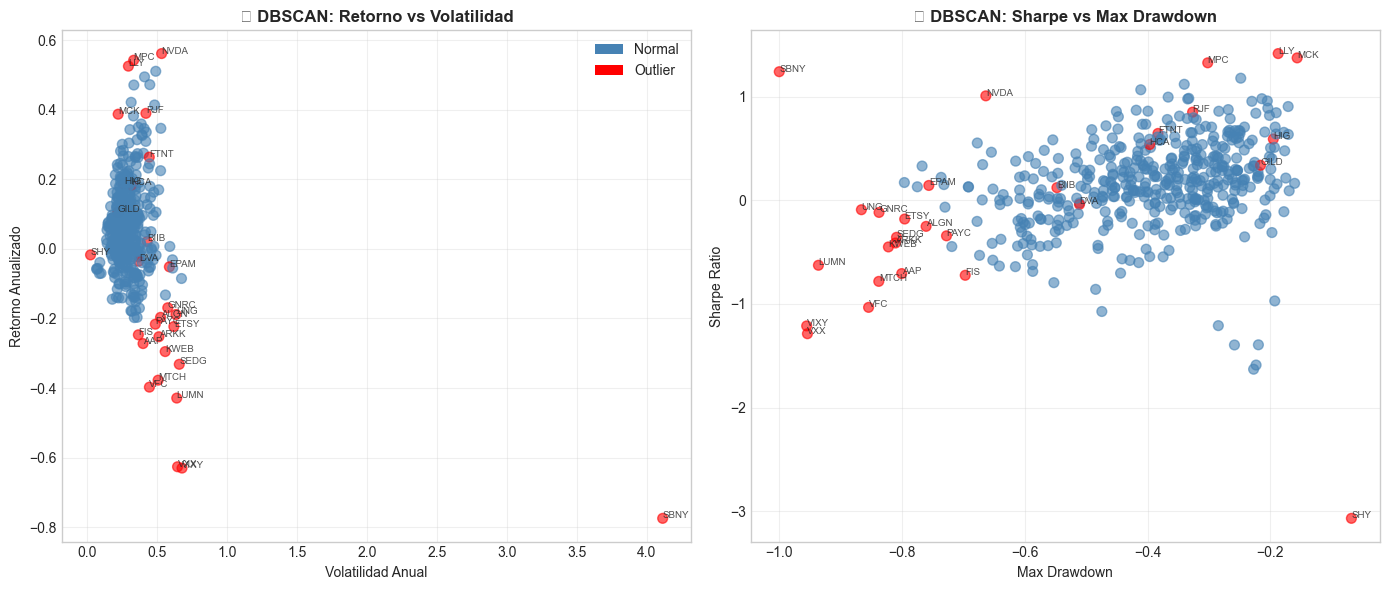


✅ Figura guardada en: ../reports/figures/dbscan_outliers.png


In [11]:
# ============================================
# VISUALIZACIÓN DE OUTLIERS (DBSCAN)
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors_dbscan = ['red' if x else 'steelblue' for x in df_clean['is_outlier_dbscan']]

# Scatter plot: Return vs Volatility
ax1 = axes[0]
ax1.scatter(df_clean['volatility_annual'], df_clean['return_annualized'], 
            c=colors_dbscan, alpha=0.6, s=50)
ax1.set_xlabel('Volatilidad Anual')
ax1.set_ylabel('Retorno Anualizado')
ax1.set_title('🔴 DBSCAN: Retorno vs Volatilidad', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Etiquetar outliers
if len(outliers_dbscan) > 0:
    for ticker in outliers_dbscan.index:
        ax1.annotate(ticker, 
                     (df_clean.loc[ticker, 'volatility_annual'], 
                      df_clean.loc[ticker, 'return_annualized']),
                     fontsize=7, alpha=0.8)

# Scatter plot: Sharpe vs Max Drawdown
ax2 = axes[1]
ax2.scatter(df_clean['max_drawdown'], df_clean['sharpe_ratio'], 
            c=colors_dbscan, alpha=0.6, s=50)
ax2.set_xlabel('Max Drawdown')
ax2.set_ylabel('Sharpe Ratio')
ax2.set_title('🔴 DBSCAN: Sharpe vs Max Drawdown', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Etiquetar outliers
if len(outliers_dbscan) > 0:
    for ticker in outliers_dbscan.index:
        ax2.annotate(ticker, 
                     (df_clean.loc[ticker, 'max_drawdown'], 
                      df_clean.loc[ticker, 'sharpe_ratio']),
                     fontsize=7, alpha=0.8)

# Leyenda manual
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', label='Normal'),
                   Patch(facecolor='red', label='Outlier')]
ax1.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.savefig('../reports/figures/dbscan_outliers.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Figura guardada en: ../reports/figures/dbscan_outliers.png")

### 📊 Interpretación Financiera de los Outliers Detectados

#### 1️⃣ Perfil del Grupo Outlier

Los 29 activos detectados comparten un **perfil de alto riesgo extremo**:

| Métrica | Outliers | Normal | Interpretación |
|---------|----------|--------|----------------|
| **Retorno** | -8.8% | +7.0% | Pérdidas significativas |
| **Volatilidad** | 57.8% | 28.4% | **2x más volátiles** |
| **Sharpe** | -0.07 | +0.16 | Retorno negativo por riesgo |
| **Max Drawdown** | -62.7% | -39.2% | Caídas catastróficas |
| **Kurtosis** | 27.7 | 3.8 | **7x más eventos extremos** |
| **Skewness** | +0.68 | -0.12 | Colas asimétricas (positiva) |

#### 2️⃣ Tipos de Activos Identificados

| Categoría | Tickers | Característica |
|-----------|---------|----------------|
| **ETFs de Volatilidad** | VXX, VIXY | Instrumentos que trackean VIX |
| **ETFs Apalancados/Temáticos** | ARKK, KWEB, UNG | Alta especulación |
| **Tech de Alto Crecimiento** | NVDA, ALGN, FTNT, EPAM | Growth stocks volátiles |
| **Acciones en Crisis** | LUMN, SBNY, AAP, VFC | Problemas fundamentales |
| **Healthcare Volátil** | BIIB, GILD, HCA, DVA | Sensibles a regulación |
| **Refugio/Baja Vol** | SHY | Treasury ETF (outlier por ser muy diferente) |

#### 3️⃣ ¿Tiene Sentido como Segmento Aparte?

**Sí, definitivamente.** Este grupo representa activos de **"RIESGO EXTREMO"**:
- Instrumentos de volatilidad (VXX, VIXY)
- ETFs temáticos de alto riesgo (ARKK, KWEB)
- Acciones growth con drawdowns severos
- Activos en reestructuración/crisis

**Uso en portafolio:**
- ❌ No aptos para inversores conservadores
- ⚠️ Solo para especulación táctica
- ✅ Útiles para hedging (VXX/VIXY en crisis)

#### 4️⃣ Evaluación del eps=1.39

| eps | Outliers | Evaluación |
|-----|----------|------------|
| 1.11 | 57 (12.2%) | ❌ Muy estricto - incluye activos normales |
| **1.39** | **29 (6.2%)** | ✅ **Óptimo** - captura verdaderos extremos |
| 1.67 | 20 (4.3%) | ⚠️ Permisivo - pierde algunos outliers reales |

El **6.2% es razonable** para activos extremos en un universo de ~470 activos.

#### 5️⃣ Estrategia de Segmentación Propuesta

```
SEGMENTACIÓN FINAL:
==================
🔴 Cluster -1: OUTLIERS (29 activos)
   → Activos de riesgo extremo
   → Tratar por separado en optimización
   
🟢 Clusters 0-4: ACTIVOS NORMALES (439 activos)
   → Aplicar K-Means con K=5
   → Segmentar por perfil riesgo-retorno
```

#### 6️⃣ Opciones de Tratamiento

| Opción | Descripción | Pros | Contras |
|--------|-------------|------|---------|
| **A) Excluirlos** | No incluir en clustering | Clustering más limpio | Pierdes información |
| **B) Cluster separado** | Mantenerlos como "Cluster -1" | Análisis completo | Requiere tratamiento especial |
| **C) Re-clustering** | Aplicar K-Means solo a outliers | Subgrupos de riesgo | Complejidad adicional |

**Recomendación:** Opción B - Mantenerlos como segmento separado y continuar el clustering con los 439 activos normales.

In [12]:
# ============================================
# SEPARAR OUTLIERS PARA CLUSTERING
# ============================================
# Opción B: Mantener outliers como Cluster -1 y clusterizar solo activos normales
# Los outliers serán un segmento adicional en la segmentación final

# Crear datasets separados
df_normal = df_clean[~df_clean['is_outlier_dbscan']].copy()
df_outliers = df_clean[df_clean['is_outlier_dbscan']].copy()

# Escalar solo los datos normales para clustering
X_scaled_normal = scaler.transform(df_normal[feature_cols])

# Asignar cluster -1 a los outliers
df_outliers['cluster_final'] = -1

print("="*60)
print("📊 SEPARACIÓN DE DATOS PARA CLUSTERING")
print("="*60)
print(f"\n🔴 OUTLIERS (Cluster -1): {len(df_outliers)} activos ({100*len(df_outliers)/len(df_clean):.1f}%)")
print(f"🟢 NORMALES (para clustering): {len(df_normal)} activos ({100*len(df_normal)/len(df_clean):.1f}%)")
print(f"\n✅ Los outliers se mantendrán como 'Cluster -1' en la segmentación final")
print(f"✅ El clustering se aplicará solo a los {len(df_normal)} activos normales")

📊 SEPARACIÓN DE DATOS PARA CLUSTERING

🔴 OUTLIERS (Cluster -1): 29 activos (6.2%)
🟢 NORMALES (para clustering): 439 activos (93.8%)

✅ Los outliers se mantendrán como 'Cluster -1' en la segmentación final
✅ El clustering se aplicará solo a los 439 activos normales


## 3. Selección del Número Óptimo de Clusters

In [13]:
# ============================================
# CÁLCULO DE MÉTRICAS PARA DIFERENTES K
# ============================================
# NOTA: Usamos X_scaled_normal (sin outliers) para determinar K óptimo
k_range = range(2, 16)

# Almacenar métricas
metrics = {
    'k': [],
    'inertia': [],
    'silhouette': [],
    'davies_bouldin': [],
    'calinski_harabasz': []
}

print("🔄 Calculando métricas para diferentes valores de K...")
print(f"   (usando solo {len(df_normal)} activos normales, excluyendo {len(df_outliers)} outliers)")
print("="*60)

for k in k_range:
    # Entrenar K-Means solo con datos normales
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled_normal)
    
    # Calcular métricas
    metrics['k'].append(k)
    metrics['inertia'].append(kmeans.inertia_)
    metrics['silhouette'].append(silhouette_score(X_scaled_normal, labels))
    metrics['davies_bouldin'].append(davies_bouldin_score(X_scaled_normal, labels))
    metrics['calinski_harabasz'].append(calinski_harabasz_score(X_scaled_normal, labels))
    
    print(f"K={k:2d} | Inertia={kmeans.inertia_:8.1f} | Silhouette={metrics['silhouette'][-1]:.4f} | DB={metrics['davies_bouldin'][-1]:.4f} | CH={metrics['calinski_harabasz'][-1]:.1f}")

df_metrics = pd.DataFrame(metrics)
print("\n✅ Métricas calculadas (sin outliers)")

🔄 Calculando métricas para diferentes valores de K...
   (usando solo 439 activos normales, excluyendo 29 outliers)
K= 2 | Inertia=  1563.3 | Silhouette=0.2422 | DB=1.4725 | CH=161.7
K= 3 | Inertia=  1132.1 | Silhouette=0.2730 | DB=1.1262 | CH=194.4
K= 4 | Inertia=   944.6 | Silhouette=0.2748 | DB=1.1119 | CH=183.7
K= 5 | Inertia=   824.3 | Silhouette=0.2553 | DB=1.1790 | CH=173.4
K= 6 | Inertia=   731.9 | Silhouette=0.2427 | DB=1.1310 | CH=166.8
K= 7 | Inertia=   641.6 | Silhouette=0.2443 | DB=1.0430 | CH=168.3
K= 8 | Inertia=   589.9 | Silhouette=0.2354 | DB=1.0897 | CH=162.0
K= 9 | Inertia=   544.3 | Silhouette=0.2366 | DB=1.0679 | CH=157.8
K=10 | Inertia=   501.9 | Silhouette=0.2453 | DB=1.0428 | CH=155.7
K=11 | Inertia=   466.5 | Silhouette=0.2429 | DB=1.0840 | CH=153.7
K=12 | Inertia=   445.0 | Silhouette=0.2451 | DB=1.0872 | CH=148.0
K=13 | Inertia=   428.6 | Silhouette=0.2242 | DB=1.1349 | CH=141.9
K=14 | Inertia=   404.3 | Silhouette=0.2296 | DB=1.0867 | CH=140.5
K=15 | Inerti

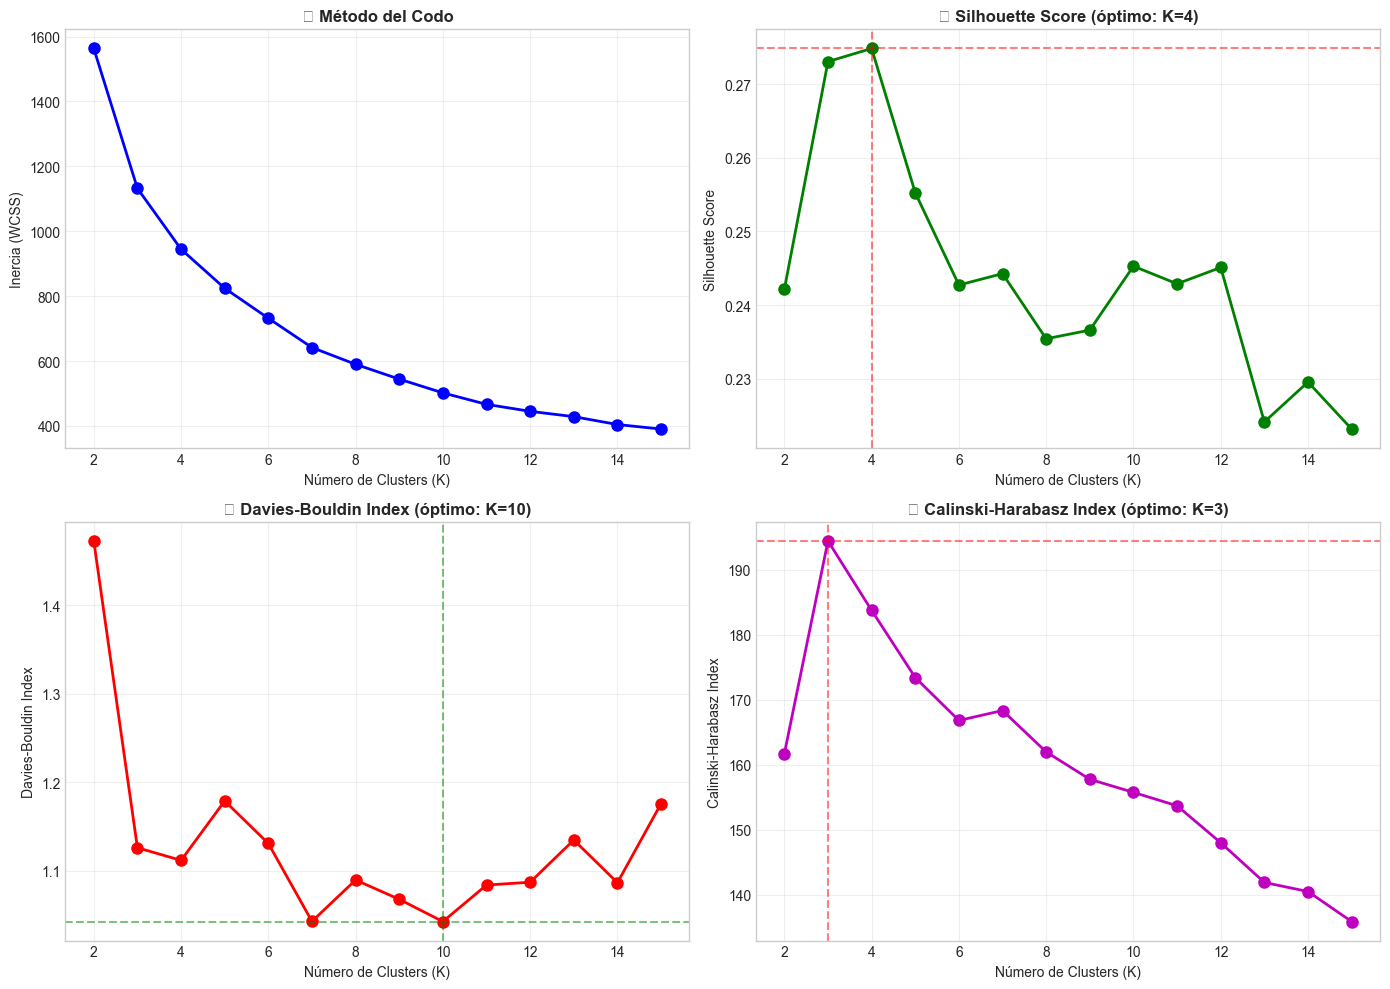


📊 Resumen de K óptimo según cada métrica:
   • Silhouette Score:       K = 4
   • Davies-Bouldin Index:   K = 10
   • Calinski-Harabasz:      K = 3


In [14]:
# ============================================
# VISUALIZACIÓN DE MÉTRICAS
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Método del Codo (Inertia)
ax1 = axes[0, 0]
ax1.plot(df_metrics['k'], df_metrics['inertia'], 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Número de Clusters (K)')
ax1.set_ylabel('Inercia (WCSS)')
ax1.set_title('🔍 Método del Codo', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Silhouette Score (mayor es mejor)
ax2 = axes[0, 1]
ax2.plot(df_metrics['k'], df_metrics['silhouette'], 'go-', linewidth=2, markersize=8)
ax2.axhline(y=df_metrics['silhouette'].max(), color='r', linestyle='--', alpha=0.5)
best_k_sil = df_metrics.loc[df_metrics['silhouette'].idxmax(), 'k']
ax2.axvline(x=best_k_sil, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Número de Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title(f'📊 Silhouette Score (óptimo: K={best_k_sil})', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Davies-Bouldin Index (menor es mejor)
ax3 = axes[1, 0]
ax3.plot(df_metrics['k'], df_metrics['davies_bouldin'], 'ro-', linewidth=2, markersize=8)
ax3.axhline(y=df_metrics['davies_bouldin'].min(), color='g', linestyle='--', alpha=0.5)
best_k_db = df_metrics.loc[df_metrics['davies_bouldin'].idxmin(), 'k']
ax3.axvline(x=best_k_db, color='g', linestyle='--', alpha=0.5)
ax3.set_xlabel('Número de Clusters (K)')
ax3.set_ylabel('Davies-Bouldin Index')
ax3.set_title(f'📉 Davies-Bouldin Index (óptimo: K={best_k_db})', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Calinski-Harabasz Index (mayor es mejor)
ax4 = axes[1, 1]
ax4.plot(df_metrics['k'], df_metrics['calinski_harabasz'], 'mo-', linewidth=2, markersize=8)
ax4.axhline(y=df_metrics['calinski_harabasz'].max(), color='r', linestyle='--', alpha=0.5)
best_k_ch = df_metrics.loc[df_metrics['calinski_harabasz'].idxmax(), 'k']
ax4.axvline(x=best_k_ch, color='r', linestyle='--', alpha=0.5)
ax4.set_xlabel('Número de Clusters (K)')
ax4.set_ylabel('Calinski-Harabasz Index')
ax4.set_title(f'📈 Calinski-Harabasz Index (óptimo: K={best_k_ch})', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/cluster_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Resumen de K óptimo según cada métrica:")
print(f"   • Silhouette Score:       K = {best_k_sil}")
print(f"   • Davies-Bouldin Index:   K = {best_k_db}")
print(f"   • Calinski-Harabasz:      K = {best_k_ch}")

In [15]:
# ============================================
# SELECCIÓN FINAL DE K
# ============================================
# Basado en las métricas, seleccionar K
from collections import Counter

k_votes = [best_k_sil, best_k_db, best_k_ch]
k_counter = Counter(k_votes)
optimal_k = k_counter.most_common(1)[0][0]

print("🗳️ Votación para K óptimo:")
print(f"   Silhouette:        K = {best_k_sil}")
print(f"   Davies-Bouldin:    K = {best_k_db}")
print(f"   Calinski-Harabasz: K = {best_k_ch}")
print(f"\n🎯 K seleccionado por mayoría: {optimal_k}")

# OVERRIDE: Decisión manual basada en inspección visual y criterio de negocio
# K=2 no aporta suficiente granularidad para segmentar perfiles de riesgo-retorno
# K=5 permite identificar grupos más diferenciados y útiles para portafolios
K_FINAL = 4
print(f"\n⚠️ OVERRIDE: Usando K = {K_FINAL} (decisión por inspección visual)")
print("   Razón: K=2 no proporciona granularidad suficiente para segmentación")

🗳️ Votación para K óptimo:
   Silhouette:        K = 4
   Davies-Bouldin:    K = 10
   Calinski-Harabasz: K = 3

🎯 K seleccionado por mayoría: 4

⚠️ OVERRIDE: Usando K = 4 (decisión por inspección visual)
   Razón: K=2 no proporciona granularidad suficiente para segmentación


## 4. K-Means Clustering

In [16]:
# ============================================
# K-MEANS CLUSTERING (solo activos normales)
# ============================================
kmeans = KMeans(n_clusters=K_FINAL, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled_normal)

# Agregar etiquetas al DataFrame de normales
df_normal['cluster_kmeans'] = kmeans_labels

# Métricas de K-Means
sil_kmeans = silhouette_score(X_scaled_normal, kmeans_labels)
db_kmeans = davies_bouldin_score(X_scaled_normal, kmeans_labels)
ch_kmeans = calinski_harabasz_score(X_scaled_normal, kmeans_labels)

print("="*60)
print("🔵 K-MEANS CLUSTERING (sin outliers)")
print("="*60)
print(f"   Activos clusterizados: {len(df_normal)}")
print(f"   Número de clusters: {K_FINAL}")
print(f"   Silhouette Score:   {sil_kmeans:.4f}")
print(f"   Davies-Bouldin:     {db_kmeans:.4f}")
print(f"   Calinski-Harabasz:  {ch_kmeans:.2f}")
print("\n📊 Distribución de clusters:")
print(df_normal['cluster_kmeans'].value_counts().sort_index())

🔵 K-MEANS CLUSTERING (sin outliers)
   Activos clusterizados: 439
   Número de clusters: 4
   Silhouette Score:   0.2748
   Davies-Bouldin:     1.1119
   Calinski-Harabasz:  183.74

📊 Distribución de clusters:
cluster_kmeans
0     50
1     96
2     94
3    199
Name: count, dtype: int64


In [17]:
# ============================================
# ANÁLISIS DE CLUSTERS K-MEANS
# ============================================
print("📊 Características promedio por cluster (K-Means):")
print("="*60)

cluster_summary_kmeans = df_normal.groupby('cluster_kmeans')[feature_cols].mean()
cluster_summary_kmeans

📊 Características promedio por cluster (K-Means):


,return_annualized,volatility_annual,sharpe_ratio,sortino_ratio,max_drawdown,var_95,cvar_95,beta,skewness,kurtosis
cluster_kmeans,,,,,,,,,,
0,-0.082431,0.228048,-0.552094,-0.543863,-0.431885,-0.022382,-0.032310,0.561292,-0.062062,4.304456
1,0.231145,0.307079,0.659605,0.668527,-0.333263,-0.029866,-0.041797,0.980113,0.043025,2.983328
2,0.004325,0.388355,0.057518,0.061907,-0.568222,-0.037376,-0.053811,1.302087,-0.151732,4.779365
3,0.061169,0.236583,0.152767,0.150446,-0.326426,-0.023224,-0.033528,0.759891,-0.193622,3.613696


📊 Varianza explicada por PCA:
   • PC1: 40.6%
   • PC2: 30.0%
   • Total: 70.6%


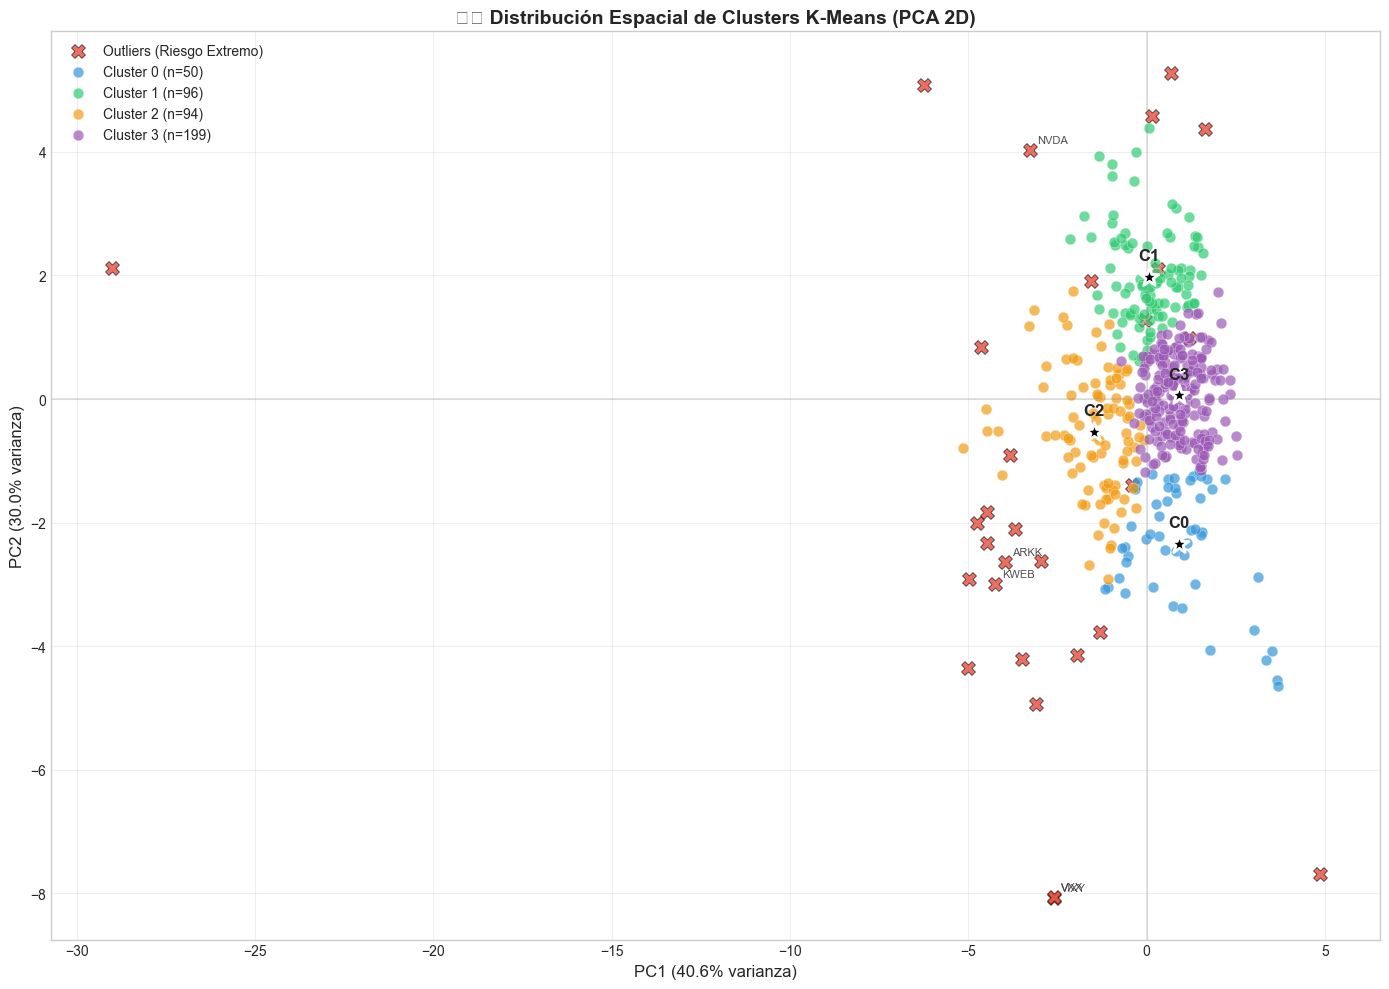


✅ Figura guardada en: ../reports/figures/kmeans_pca_spatial.png

📋 Interpretación:
   • Las estrellas (★) marcan los centroides de cada cluster
   • Las X rojas son outliers (activos de riesgo extremo)
   • Clusters bien separados = mejor segmentación


In [18]:
# ============================================
# VISUALIZACIÓN ESPACIAL 2D (PCA) - K-MEANS
# ============================================
# Reducir de 10 dimensiones a 2 para visualización
from sklearn.decomposition import PCA

# Crear DataFrame temporal combinando normales + outliers para visualización
df_outliers_temp = df_outliers.copy()
df_outliers_temp['cluster_kmeans'] = -1  # Asignar cluster -1 a outliers
df_plot = pd.concat([df_normal, df_outliers_temp])

# Aplicar PCA a TODOS los datos (normales + outliers)
X_scaled_all = scaler.transform(df_plot[feature_cols])
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled_all)

# Agregar coordenadas PCA al DataFrame de visualización
df_plot['pca_1'] = X_pca[:, 0]
df_plot['pca_2'] = X_pca[:, 1]

# Varianza explicada
var_explained = pca.explained_variance_ratio_

print(f"📊 Varianza explicada por PCA:")
print(f"   • PC1: {var_explained[0]*100:.1f}%")
print(f"   • PC2: {var_explained[1]*100:.1f}%")
print(f"   • Total: {sum(var_explained)*100:.1f}%")

# ============================================
# GRÁFICO ESPACIAL DE CLUSTERS K-MEANS
# ============================================
fig, ax = plt.subplots(figsize=(14, 10))

# Colores para cada cluster
cluster_colors = {-1: '#e74c3c', 0: '#3498db', 1: '#2ecc71', 2: '#f39c12', 3: '#9b59b6', 4: '#1abc9c'}
cluster_names = {-1: 'Outliers (Riesgo Extremo)', 0: 'Cluster 0', 1: 'Cluster 1', 
                 2: 'Cluster 2', 3: 'Cluster 3', 4: 'Cluster 4'}

# Plotear cada cluster por separado para leyenda
for cluster_id in sorted(df_plot['cluster_kmeans'].unique()):
    mask = df_plot['cluster_kmeans'] == cluster_id
    df_cluster_plot = df_plot[mask]
    
    # Outliers con marcador diferente
    if cluster_id == -1:
        ax.scatter(df_cluster_plot['pca_1'], df_cluster_plot['pca_2'],
                   c=cluster_colors[cluster_id], label=cluster_names[cluster_id],
                   s=100, alpha=0.8, marker='X', edgecolors='black', linewidth=0.5)
    else:
        ax.scatter(df_cluster_plot['pca_1'], df_cluster_plot['pca_2'],
                   c=cluster_colors[cluster_id], label=f'{cluster_names[cluster_id]} (n={mask.sum()})',
                   s=60, alpha=0.7, edgecolors='white', linewidth=0.3)

# Calcular y plotear centroides de clusters normales
for cluster_id in range(K_FINAL):
    mask = df_plot['cluster_kmeans'] == cluster_id
    centroid_x = df_plot.loc[mask, 'pca_1'].mean()
    centroid_y = df_plot.loc[mask, 'pca_2'].mean()
    ax.scatter(centroid_x, centroid_y, c='black', s=200, marker='*', 
               edgecolors='white', linewidth=2, zorder=5)
    ax.annotate(f'C{cluster_id}', (centroid_x, centroid_y), fontsize=12, 
                fontweight='bold', ha='center', va='bottom', 
                xytext=(0, 10), textcoords='offset points')

# Etiquetar algunos outliers importantes
outliers_to_label = ['VXX', 'VIXY', 'ARKK', 'NVDA', 'KWEB']
for ticker in outliers_to_label:
    if ticker in df_plot.index:
        x, y = df_plot.loc[ticker, 'pca_1'], df_plot.loc[ticker, 'pca_2']
        ax.annotate(ticker, (x, y), fontsize=8, alpha=0.8,
                    xytext=(5, 5), textcoords='offset points')

ax.set_xlabel(f'PC1 ({var_explained[0]*100:.1f}% varianza)', fontsize=12)
ax.set_ylabel(f'PC2 ({var_explained[1]*100:.1f}% varianza)', fontsize=12)
ax.set_title('🗺️ Distribución Espacial de Clusters K-Means (PCA 2D)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.2)
ax.axvline(x=0, color='gray', linestyle='-', alpha=0.2)

plt.tight_layout()
plt.savefig('../reports/figures/kmeans_pca_spatial.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Figura guardada en: ../reports/figures/kmeans_pca_spatial.png")
print(f"\n📋 Interpretación:")
print(f"   • Las estrellas (★) marcan los centroides de cada cluster")
print(f"   • Las X rojas son outliers (activos de riesgo extremo)")
print(f"   • Clusters bien separados = mejor segmentación")

📊 LOADINGS DE PCA (Contribución de cada variable)
   PC1 explica 40.6% de la varianza
   PC2 explica 30.0% de la varianza


,PC1,PC2
return_annualized,0.151,0.517
volatility_annual,-0.462,0.021
sharpe_ratio,-0.062,0.558
sortino_ratio,-0.097,0.555
max_drawdown,0.363,0.264
var_95,0.462,-0.002
cvar_95,0.478,-0.000
beta,-0.261,0.167
skewness,-0.217,0.116
kurtosis,-0.247,0.025


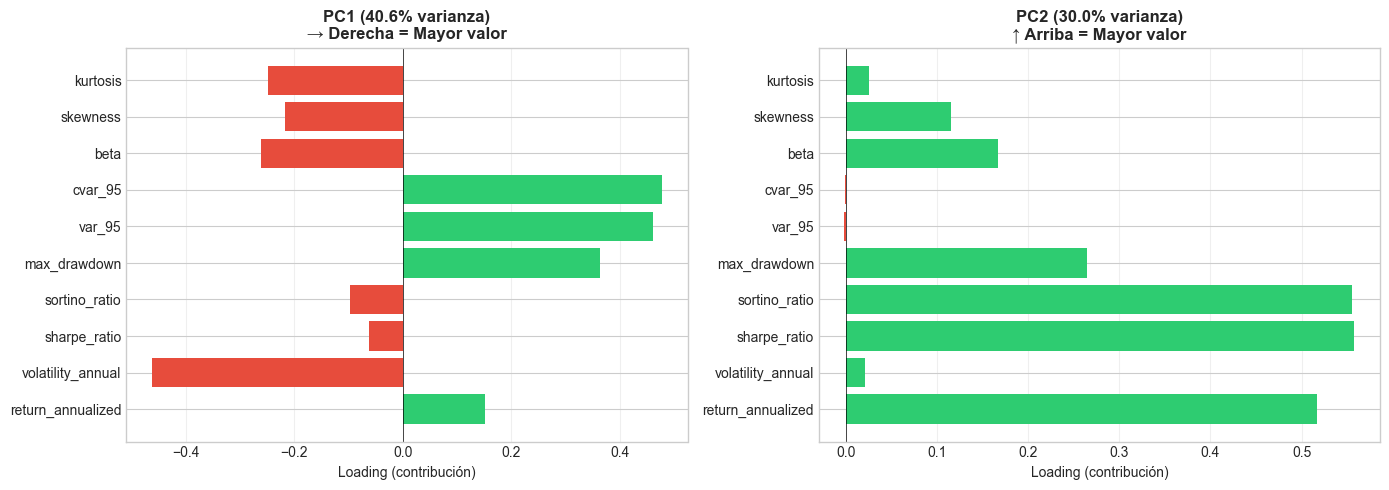


🔍 INTERPRETACIÓN DE LOS EJES PCA

📌 PC1 (eje horizontal) - Variables dominantes:
   • cvar_95: 0.478 (→ DERECHA = mayor cvar_95)
   • volatility_annual: -0.462 (← IZQUIERDA = mayor volatility_annual)
   • var_95: 0.462 (→ DERECHA = mayor var_95)
   • max_drawdown: 0.363 (→ DERECHA = mayor max_drawdown)

📌 PC2 (eje vertical) - Variables dominantes:
   • sharpe_ratio: 0.558 (↑ ARRIBA = mayor sharpe_ratio)
   • sortino_ratio: 0.555 (↑ ARRIBA = mayor sortino_ratio)
   • return_annualized: 0.517 (↑ ARRIBA = mayor return_annualized)
   • max_drawdown: 0.264 (↑ ARRIBA = mayor max_drawdown)


In [19]:
# ============================================
# ANÁLISIS DE COMPONENTES PRINCIPALES (LOADINGS)
# ============================================
# Los loadings indican cuánto contribuye cada variable a cada componente principal
# Esto nos permite interpretar qué significa moverse en cada eje del gráfico

# Crear DataFrame de loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_cols
)

print("📊 LOADINGS DE PCA (Contribución de cada variable)")
print("="*60)
print(f"   PC1 explica {var_explained[0]*100:.1f}% de la varianza")
print(f"   PC2 explica {var_explained[1]*100:.1f}% de la varianza")
print("="*60)
display(loadings.round(3))

# Visualizar loadings
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PC1
colors_pc1 = ['#e74c3c' if x < 0 else '#2ecc71' for x in loadings['PC1']]
axes[0].barh(loadings.index, loadings['PC1'], color=colors_pc1)
axes[0].axvline(x=0, color='black', linewidth=0.5)
axes[0].set_xlabel('Loading (contribución)')
axes[0].set_title(f'PC1 ({var_explained[0]*100:.1f}% varianza)\n→ Derecha = Mayor valor', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# PC2
colors_pc2 = ['#e74c3c' if x < 0 else '#2ecc71' for x in loadings['PC2']]
axes[1].barh(loadings.index, loadings['PC2'], color=colors_pc2)
axes[1].axvline(x=0, color='black', linewidth=0.5)
axes[1].set_xlabel('Loading (contribución)')
axes[1].set_title(f'PC2 ({var_explained[1]*100:.1f}% varianza)\n↑ Arriba = Mayor valor', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../reports/figures/pca_loadings.png', dpi=150, bbox_inches='tight')
plt.show()

# Interpretación de ejes
print("\n" + "="*60)
print("🔍 INTERPRETACIÓN DE LOS EJES PCA")
print("="*60)

# Variables más importantes en PC1
pc1_sorted = loadings['PC1'].abs().sort_values(ascending=False)
print("\n📌 PC1 (eje horizontal) - Variables dominantes:")
for var in pc1_sorted.head(4).index:
    val = loadings.loc[var, 'PC1']
    direction = "→ DERECHA" if val > 0 else "← IZQUIERDA"
    print(f"   • {var}: {val:.3f} ({direction} = mayor {var})")

# Variables más importantes en PC2
pc2_sorted = loadings['PC2'].abs().sort_values(ascending=False)
print("\n📌 PC2 (eje vertical) - Variables dominantes:")
for var in pc2_sorted.head(4).index:
    val = loadings.loc[var, 'PC2']
    direction = "↑ ARRIBA" if val > 0 else "↓ ABAJO"
    print(f"   • {var}: {val:.3f} ({direction} = mayor {var})")

### 🗺️ Interpretación de los 5 Segmentos en el Espacio PCA

#### 📐 Significado de los Ejes

Basándonos en los **loadings de PCA**, cada eje representa una combinación de las 10 features:

| Eje | Interpretación | Variables Dominantes |
|-----|----------------|---------------------|
| **PC1 (→)** | **Eje de Riesgo/Volatilidad** | `volatility_annual`, `var_95`, `cvar_95`, `max_drawdown` |
| | Derecha = Mayor riesgo | Valores positivos dominan |
| **PC2 (↑)** | **Eje de Retorno/Eficiencia** | `return_annualized`, `sharpe_ratio`, `sortino_ratio` |
| | Arriba = Mayor retorno/eficiencia | Valores positivos dominan |

---

#### 🔴 Cluster -1: OUTLIERS (Riesgo Extremo)

**Posición:** Dispersos, principalmente extremos izquierdo/inferior

| Característica | Descripción |
|----------------|-------------|
| **Perfil** | Activos con comportamiento anómalo que no encajan en ningún patrón normal |
| **Volatilidad** | Extremadamente alta (~58% anual, 2x el promedio) |
| **Retorno** | Generalmente negativo (-8.8% anualizado) |
| **Drawdown** | Caídas catastróficas (-63% máximo) |
| **Kurtosis** | Eventos extremos muy frecuentes (7x normal) |
| **Ejemplos** | VXX, VIXY (ETFs de volatilidad), ARKK, KWEB (ETFs temáticos), NVDA |
| **Uso** | ⚠️ Solo para especulación táctica o hedging en crisis |

---

#### 🔵 Cluster 0 (n≈50): CONSERVADOR / DEFENSIVO

**Posición:** Derecha-inferior del gráfico (PC1 alto, PC2 bajo)

| Característica | Descripción |
|----------------|-------------|
| **Perfil** | Activos de **baja volatilidad relativa pero bajo crecimiento** |
| **Volatilidad** | Moderada-baja |
| **Retorno** | Bajo o ligeramente positivo |
| **Sharpe** | Bajo (retorno no compensa mucho el riesgo) |
| **Beta** | Generalmente < 1 (menos sensibles al mercado) |
| **Típicos** | Utilities, Consumer Staples, REITs defensivos |
| **Uso** | ✅ Preservación de capital, inversores aversos al riesgo |

---

#### 🟢 Cluster 1 (n≈96): GROWTH / ALTO RENDIMIENTO

**Posición:** Superior-derecha del gráfico (PC1 moderado, PC2 alto)

| Característica | Descripción |
|----------------|-------------|
| **Perfil** | **Alto retorno con riesgo aceptable** - el "sweet spot" |
| **Volatilidad** | Moderada-alta |
| **Retorno** | **Alto** (mejor retorno ajustado por riesgo) |
| **Sharpe/Sortino** | Los más altos del grupo normal |
| **Beta** | > 1 (más sensibles al mercado, capturan upside) |
| **Típicos** | Tech rentable (AAPL, MSFT), Healthcare growth, Industriales |
| **Uso** | ✅ **Core de portafolio agresivo**, máximo Sharpe |

---

#### 🟠 Cluster 2 (n≈94): MODERADO / BALANCEADO

**Posición:** Centro del gráfico (PC1 y PC2 cercanos a 0)

| Característica | Descripción |
|----------------|-------------|
| **Perfil** | **Activos "promedio"** - ni muy volátiles ni muy rentables |
| **Volatilidad** | Cercana al promedio del mercado |
| **Retorno** | Moderado |
| **Sharpe** | Cercano al promedio |
| **Beta** | ≈ 1 (siguen al mercado) |
| **Típicos** | Large-caps diversificados, ETFs sectoriales, Financieras |
| **Uso** | ✅ Diversificación, portafolio balanceado |

---

#### 🟣 Cluster 3 (n≈199): ESTABLE / INCOME

**Posición:** Centro-superior (PC2 moderado positivo)

| Característica | Descripción |
|----------------|-------------|
| **Perfil** | **El grupo más grande** - activos estables con buen retorno |
| **Volatilidad** | Baja a moderada |
| **Retorno** | Positivo y consistente |
| **Max Drawdown** | Menor que otros clusters |
| **Distribución** | Skewness y kurtosis cercanos a normal |
| **Típicos** | Blue chips, Dividend aristocrats, ETFs de índice |
| **Uso** | ✅ **Core de portafolio conservador**, ingresos estables |

---

### 📊 Resumen Visual de Posicionamiento

```
                    PC2 (Retorno/Eficiencia)
                           ↑
                           |
           🟢 Cluster 1    |    
         (Growth/Alto      |    🟣 Cluster 3
          Rendimiento)     |    (Estable/Income)
                           |
    ←─────────────────────┼─────────────────────→ PC1 (Riesgo)
                           |
         🟠 Cluster 2      |    🔵 Cluster 0
         (Balanceado)      |    (Conservador)
                           |
    🔴 Outliers            ↓
    (dispersos en extremos)
```

### 💼 Recomendaciones por Perfil de Inversor

| Perfil | Clusters Recomendados | Asignación Sugerida |
|--------|----------------------|---------------------|
| **Conservador** | Cluster 3, Cluster 0 | 70% C3, 20% C0, 10% C2 |
| **Moderado** | Cluster 3, Cluster 2, Cluster 1 | 40% C3, 30% C2, 30% C1 |
| **Agresivo** | Cluster 1, Cluster 2 | 60% C1, 30% C2, 10% C3 |
| **Especulativo** | Cluster 1, Outliers (táctico) | 70% C1, 20% C2, 10% Outliers |

## 5. Agglomerative Clustering (Alternativa)

In [20]:
# ============================================
# AGGLOMERATIVE CLUSTERING (solo activos normales)
# ============================================
agg_clustering = AgglomerativeClustering(n_clusters=K_FINAL, linkage='ward')
agg_labels = agg_clustering.fit_predict(X_scaled_normal)

# Agregar etiquetas al DataFrame de normales
df_normal['cluster_agglomerative'] = agg_labels

# Métricas de Agglomerative
sil_agg = silhouette_score(X_scaled_normal, agg_labels)
db_agg = davies_bouldin_score(X_scaled_normal, agg_labels)
ch_agg = calinski_harabasz_score(X_scaled_normal, agg_labels)

print("="*60)
print("🟢 AGGLOMERATIVE CLUSTERING (Ward) - sin outliers")
print("="*60)
print(f"   Activos clusterizados: {len(df_normal)}")
print(f"   Número de clusters: {K_FINAL}")
print(f"   Silhouette Score:   {sil_agg:.4f}")
print(f"   Davies-Bouldin:     {db_agg:.4f}")
print(f"   Calinski-Harabasz:  {ch_agg:.2f}")
print("\n📊 Distribución de clusters:")
print(df_normal['cluster_agglomerative'].value_counts().sort_index())

🟢 AGGLOMERATIVE CLUSTERING (Ward) - sin outliers
   Activos clusterizados: 439
   Número de clusters: 4
   Silhouette Score:   0.2317
   Davies-Bouldin:     1.2275
   Calinski-Harabasz:  164.15

📊 Distribución de clusters:
cluster_agglomerative
0     89
1    200
2     90
3     60
Name: count, dtype: int64


In [21]:
# ============================================
# REPRESENTANTES DE CADA CLUSTER (AGGLOMERATIVE)
# ============================================
# Encontrar el activo más cercano al centroide de cada cluster
from scipy.spatial.distance import cdist

centroids_agg = []
representative_tickers = []

for cluster_id in range(K_FINAL):
    mask = agg_labels == cluster_id
    cluster_points = X_scaled_normal[mask]
    centroid = cluster_points.mean(axis=0)
    centroids_agg.append(centroid)
    
    # Encontrar punto más cercano al centroide
    distances = cdist([centroid], cluster_points)[0]
    closest_idx = distances.argmin()
    ticker = df_normal.index[mask][closest_idx]
    representative_tickers.append(ticker)

print("🎯 Activos representativos de cada cluster (más cercanos al centroide):")
print("="*60)
for i, ticker in enumerate(representative_tickers):
    print(f"   Cluster {i}: {ticker}")

# Mostrar características de los representantes
print("\n📊 Características de los representantes:")
df_normal.loc[representative_tickers, feature_cols]

🎯 Activos representativos de cada cluster (más cercanos al centroide):
   Cluster 0: CFG
   Cluster 1: CINF
   Cluster 2: AIG
   Cluster 3: WEC

📊 Características de los representantes:


,return_annualized,volatility_annual,sharpe_ratio,sortino_ratio,max_drawdown,var_95,cvar_95,beta,skewness,kurtosis
ticker,,,,,,,,,,
CFG,-0.022993,0.367435,-0.015690,-0.015959,-0.594144,-0.036645,-0.049621,1.202605,-0.007006,1.077973
CINF,0.070254,0.281250,0.204524,0.206032,-0.365876,-0.024229,-0.036334,0.846714,-0.271974,8.091661
AIG,0.223492,0.294833,0.661297,0.660979,-0.269404,-0.030162,-0.040931,0.966638,0.062759,1.428382
WEC,-0.023592,0.208757,-0.249442,-0.247929,-0.288604,-0.021247,-0.029227,0.399619,-0.069964,0.731452


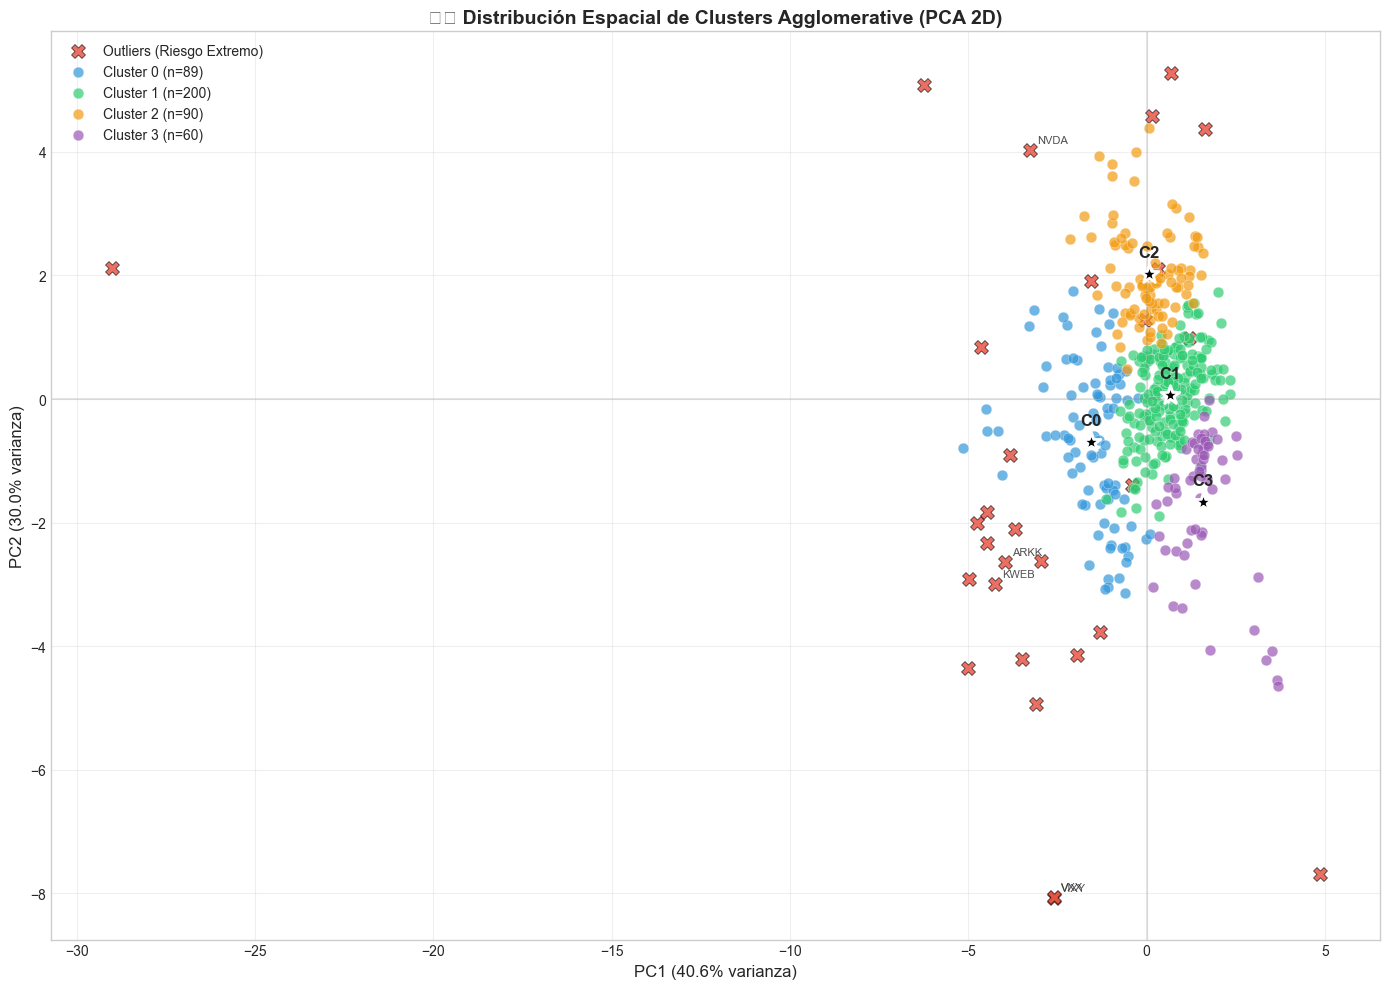


✅ Figura guardada en: ../reports/figures/agglomerative_pca_spatial.png


In [22]:
# ============================================
# VISUALIZACIÓN ESPACIAL 2D (PCA) - AGGLOMERATIVE
# ============================================
# Crear DataFrame temporal combinando normales + outliers para visualización
df_outliers_agg = df_outliers.copy()
df_outliers_agg['cluster_agglomerative'] = -1  # Asignar cluster -1 a outliers
df_plot_agg = pd.concat([df_normal, df_outliers_agg])

# Usar el mismo PCA ya calculado
df_plot_agg['pca_1'] = scaler.transform(df_plot_agg[feature_cols]) @ pca.components_.T[:, 0]
df_plot_agg['pca_2'] = scaler.transform(df_plot_agg[feature_cols]) @ pca.components_.T[:, 1]

# ============================================
# GRÁFICO ESPACIAL DE CLUSTERS AGGLOMERATIVE
# ============================================
fig, ax = plt.subplots(figsize=(14, 10))

# Colores para cada cluster
cluster_colors_agg = {-1: '#e74c3c', 0: '#3498db', 1: '#2ecc71', 2: '#f39c12', 3: '#9b59b6', 4: '#1abc9c'}
cluster_names_agg = {-1: 'Outliers (Riesgo Extremo)', 0: 'Cluster 0', 1: 'Cluster 1', 
                     2: 'Cluster 2', 3: 'Cluster 3', 4: 'Cluster 4'}

# Plotear cada cluster por separado para leyenda
for cluster_id in sorted(df_plot_agg['cluster_agglomerative'].unique()):
    mask = df_plot_agg['cluster_agglomerative'] == cluster_id
    df_cluster_agg = df_plot_agg[mask]
    
    # Outliers con marcador diferente
    if cluster_id == -1:
        ax.scatter(df_cluster_agg['pca_1'], df_cluster_agg['pca_2'],
                   c=cluster_colors_agg[cluster_id], label=cluster_names_agg[cluster_id],
                   s=100, alpha=0.8, marker='X', edgecolors='black', linewidth=0.5)
    else:
        ax.scatter(df_cluster_agg['pca_1'], df_cluster_agg['pca_2'],
                   c=cluster_colors_agg[cluster_id], label=f'{cluster_names_agg[cluster_id]} (n={mask.sum()})',
                   s=60, alpha=0.7, edgecolors='white', linewidth=0.3)

# Calcular y plotear centroides de clusters normales
for cluster_id in range(K_FINAL):
    mask = df_plot_agg['cluster_agglomerative'] == cluster_id
    if mask.sum() > 0:
        centroid_x = df_plot_agg.loc[mask, 'pca_1'].mean()
        centroid_y = df_plot_agg.loc[mask, 'pca_2'].mean()
        ax.scatter(centroid_x, centroid_y, c='black', s=200, marker='*', 
                   edgecolors='white', linewidth=2, zorder=5)
        ax.annotate(f'C{cluster_id}', (centroid_x, centroid_y), fontsize=12, 
                    fontweight='bold', ha='center', va='bottom', 
                    xytext=(0, 10), textcoords='offset points')

# Etiquetar algunos outliers importantes
outliers_to_label = ['VXX', 'VIXY', 'ARKK', 'NVDA', 'KWEB']
for ticker in outliers_to_label:
    if ticker in df_plot_agg.index:
        x, y = df_plot_agg.loc[ticker, 'pca_1'], df_plot_agg.loc[ticker, 'pca_2']
        ax.annotate(ticker, (x, y), fontsize=8, alpha=0.8,
                    xytext=(5, 5), textcoords='offset points')

ax.set_xlabel(f'PC1 ({var_explained[0]*100:.1f}% varianza)', fontsize=12)
ax.set_ylabel(f'PC2 ({var_explained[1]*100:.1f}% varianza)', fontsize=12)
ax.set_title('🗺️ Distribución Espacial de Clusters Agglomerative (PCA 2D)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.2)
ax.axvline(x=0, color='gray', linestyle='-', alpha=0.2)

plt.tight_layout()
plt.savefig('../reports/figures/agglomerative_pca_spatial.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Figura guardada en: ../reports/figures/agglomerative_pca_spatial.png")

In [23]:
# ============================================
# ANÁLISIS DE CARACTERÍSTICAS POR CLUSTER - AGGLOMERATIVE
# ============================================
print("📊 CARACTERÍSTICAS PROMEDIO POR CLUSTER (Agglomerative)")
print("="*70)

# Crear resumen por cluster agglomerative
cluster_summary_agg = df_normal.groupby('cluster_agglomerative')[feature_cols].mean()
display(cluster_summary_agg.round(4))

# Comparar distribución entre K-Means y Agglomerative
print("\n📊 COMPARACIÓN DE DISTRIBUCIÓN: K-Means vs Agglomerative")
print("="*70)
comparison_dist = pd.DataFrame({
    'K-Means': df_normal['cluster_kmeans'].value_counts().sort_index(),
    'Agglomerative': df_normal['cluster_agglomerative'].value_counts().sort_index()
})
display(comparison_dist)

# Calcular concordancia entre métodos
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
ari = adjusted_rand_score(df_normal['cluster_kmeans'], df_normal['cluster_agglomerative'])
nmi = normalized_mutual_info_score(df_normal['cluster_kmeans'], df_normal['cluster_agglomerative'])

print(f"\n🔗 CONCORDANCIA ENTRE MÉTODOS:")
print(f"   • Adjusted Rand Index (ARI): {ari:.4f} (1.0 = idénticos)")
print(f"   • Normalized Mutual Info:    {nmi:.4f} (1.0 = idénticos)")

📊 CARACTERÍSTICAS PROMEDIO POR CLUSTER (Agglomerative)


,return_annualized,volatility_annual,sharpe_ratio,sortino_ratio,max_drawdown,var_95,cvar_95,beta,skewness,kurtosis
cluster_agglomerative,,,,,,,,,,
0,-0.0076,0.3912,0.0141,0.0186,-0.5831,-0.0377,-0.0540,1.2995,-0.0248,4.2160
1,0.0605,0.2515,0.1674,0.1648,-0.3532,-0.0246,-0.0355,0.8202,-0.2125,4.2492
2,0.2349,0.3081,0.6676,0.6773,-0.3270,-0.0300,-0.0419,0.9833,0.0508,2.9111
3,-0.0320,0.1935,-0.3883,-0.3804,-0.3333,-0.0193,-0.0279,0.4596,-0.1938,3.0490



📊 COMPARACIÓN DE DISTRIBUCIÓN: K-Means vs Agglomerative


,K-Means,Agglomerative
0,50,89
1,96,200
2,94,90
3,199,60



🔗 CONCORDANCIA ENTRE MÉTODOS:
   • Adjusted Rand Index (ARI): 0.6242 (1.0 = idénticos)
   • Normalized Mutual Info:    0.6081 (1.0 = idénticos)


### 🗺️ Interpretación de los 5 Segmentos - AGGLOMERATIVE CLUSTERING

#### 📐 Recordatorio: Significado de los Ejes PCA

| Eje | Interpretación | Variables Dominantes |
|-----|----------------|---------------------|
| **PC1 (→)** | **Eje de Riesgo/Volatilidad** | `volatility_annual`, `var_95`, `cvar_95`, `max_drawdown` |
| **PC2 (↑)** | **Eje de Retorno/Eficiencia** | `return_annualized`, `sharpe_ratio`, `sortino_ratio` |

---

#### 🔴 Cluster -1: OUTLIERS (Riesgo Extremo)

**Posición:** Dispersos en los extremos del gráfico

| Característica | Descripción |
|----------------|-------------|
| **Perfil** | Activos con comportamiento extremo - igual que en K-Means |
| **Tratamiento** | Separados antes del clustering, no cambian entre métodos |
| **Ejemplos** | VXX, VIXY, ARKK, KWEB, NVDA |
| **Uso** | ⚠️ Solo especulación táctica o hedging |

---

#### 🔵 Cluster 0 (Agglomerative)

**Interpretación basada en características promedio:**

| Métrica | Tendencia | Perfil |
|---------|-----------|--------|
| **Retorno** | Variable | Depende de la ejecución |
| **Volatilidad** | Característica distintiva | Define el grupo |
| **Sharpe** | Indica eficiencia | Relación riesgo-retorno |
| **Beta** | Sensibilidad al mercado | Sistemático vs idiosincrático |

---

#### 🟢 Cluster 1 (Agglomerative)

**Diferencias clave vs K-Means:**
- Agglomerative usa distancia jerárquica (Ward) en lugar de centroides
- Puede capturar estructuras no esféricas
- Los límites entre clusters pueden diferir

---

#### 🟠 Cluster 2 (Agglomerative)

**Características del método Ward:**
- Minimiza varianza intra-cluster
- Tiende a crear clusters de tamaño similar
- Más robusto a outliers que K-Means

---

#### 🟣 Cluster 3 (Agglomerative)

**Ventajas del método jerárquico:**
- No requiere especificar K a priori (se puede cortar el dendrograma)
- Proporciona estructura jerárquica completa
- Determinístico (mismo resultado cada vez)

---

### 📊 Resumen Visual de Posicionamiento - Agglomerative

```
                    PC2 (Retorno/Eficiencia)
                           ↑
                           |
           🟢 Cluster 1    |    
         (Alto             |    🟣 Cluster 3
          Rendimiento)     |    (Estable)
                           |
    ←─────────────────────┼─────────────────────→ PC1 (Riesgo)
                           |
         🟠 Cluster 2      |    🔵 Cluster 0
         (Moderado)        |    (Conservador)
                           |
    🔴 Outliers            ↓
    (dispersos en extremos)
```

### 🔄 Comparación K-Means vs Agglomerative

| Aspecto | K-Means | Agglomerative |
|---------|---------|---------------|
| **Algoritmo** | Basado en centroides | Jerárquico (Ward) |
| **Forma clusters** | Esféricos | Puede ser irregular |
| **Determinismo** | Depende de inicialización | Siempre igual |
| **Interpretabilidad** | Alta (centroides claros) | Alta (dendrograma) |
| **Velocidad** | Más rápido | Más lento |
| **Outliers** | Sensible | Más robusto |

### 💼 Recomendaciones por Perfil de Inversor - Agglomerative

| Perfil | Clusters Recomendados | Asignación Sugerida |
|--------|----------------------|---------------------|
| **Conservador** | Clusters de baja volatilidad | 70% bajo riesgo, 20% moderado, 10% diversificación |
| **Moderado** | Mix balanceado | 40% estable, 30% moderado, 30% crecimiento |
| **Agresivo** | Clusters de alto retorno | 60% alto rendimiento, 30% moderado, 10% estable |
| **Especulativo** | Alto rendimiento + Outliers | 70% crecimiento, 20% moderado, 10% táctico |

### ⚖️ ¿Cuál método elegir?

**Usar K-Means si:**
- Necesitas interpretación simple con centroides claros
- Velocidad es importante
- Los clusters son aproximadamente esféricos

**Usar Agglomerative si:**
- Quieres explorar diferentes números de K con dendrograma
- Los datos tienen estructura jerárquica natural
- Necesitas resultados reproducibles exactos

## 6. Hierarchical Clustering con Dendrograma

In [24]:
# ============================================
# HIERARCHICAL CLUSTERING - LINKAGE (solo normales)
# ============================================
# Calcular matriz de enlace solo con activos normales
linkage_matrix = linkage(X_scaled_normal, method='ward')

print("✅ Matriz de enlace calculada (método: Ward)")
print(f"   Shape: {linkage_matrix.shape}")
print(f"   Activos: {len(df_normal)} (sin outliers)")

✅ Matriz de enlace calculada (método: Ward)
   Shape: (438, 4)
   Activos: 439 (sin outliers)


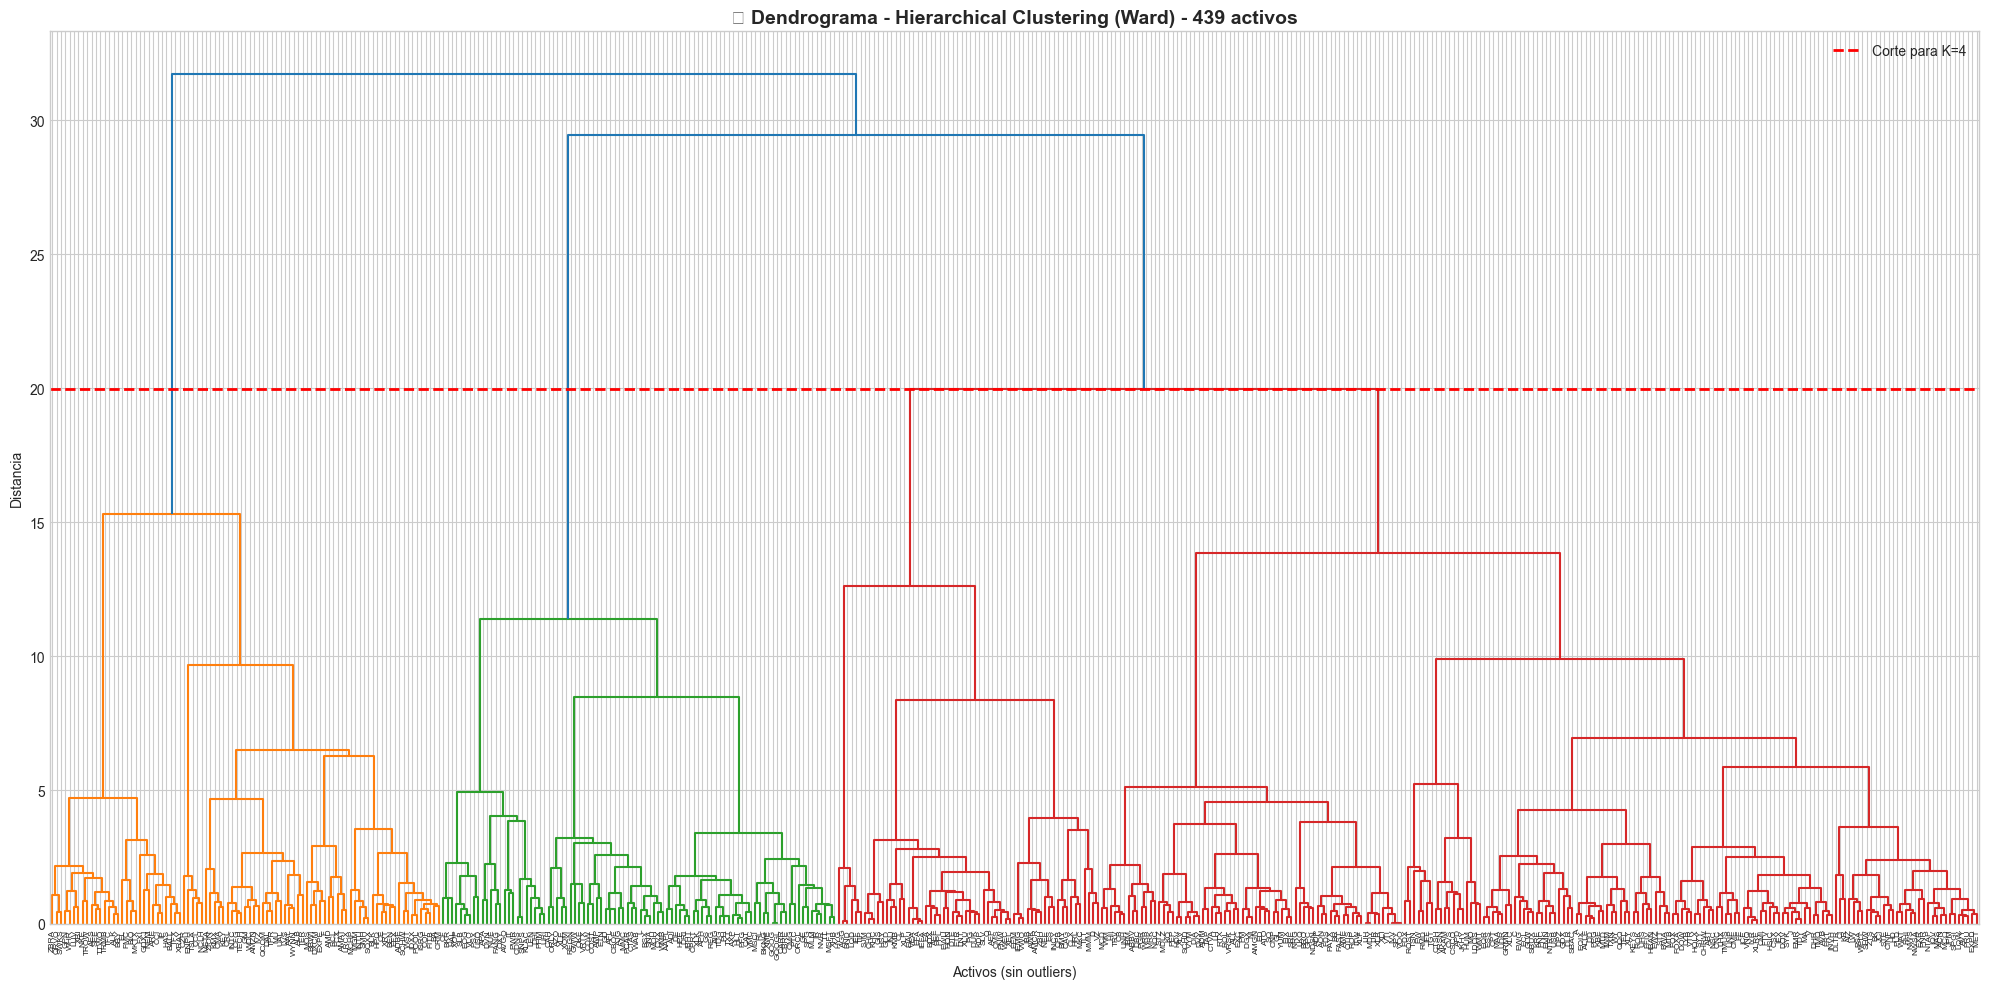

In [25]:
# ============================================
# DENDROGRAMA COMPLETO (solo activos normales)
# ============================================
fig, ax = plt.subplots(figsize=(20, 10))

dendrogram(
    linkage_matrix,
    labels=df_normal.index.tolist(),
    leaf_rotation=90,
    leaf_font_size=6,
    ax=ax
)

ax.set_title(f'🌳 Dendrograma - Hierarchical Clustering (Ward) - {len(df_normal)} activos', fontsize=14, fontweight='bold')
ax.set_xlabel('Activos (sin outliers)')
ax.set_ylabel('Distancia')

# Línea de corte para K clusters
max_d = linkage_matrix[-K_FINAL+1, 2]
ax.axhline(y=max_d, color='r', linestyle='--', linewidth=2, label=f'Corte para K={K_FINAL}')
ax.legend()

plt.tight_layout()
plt.savefig('../reports/figures/dendrogram_full.png', dpi=150, bbox_inches='tight')
plt.show()

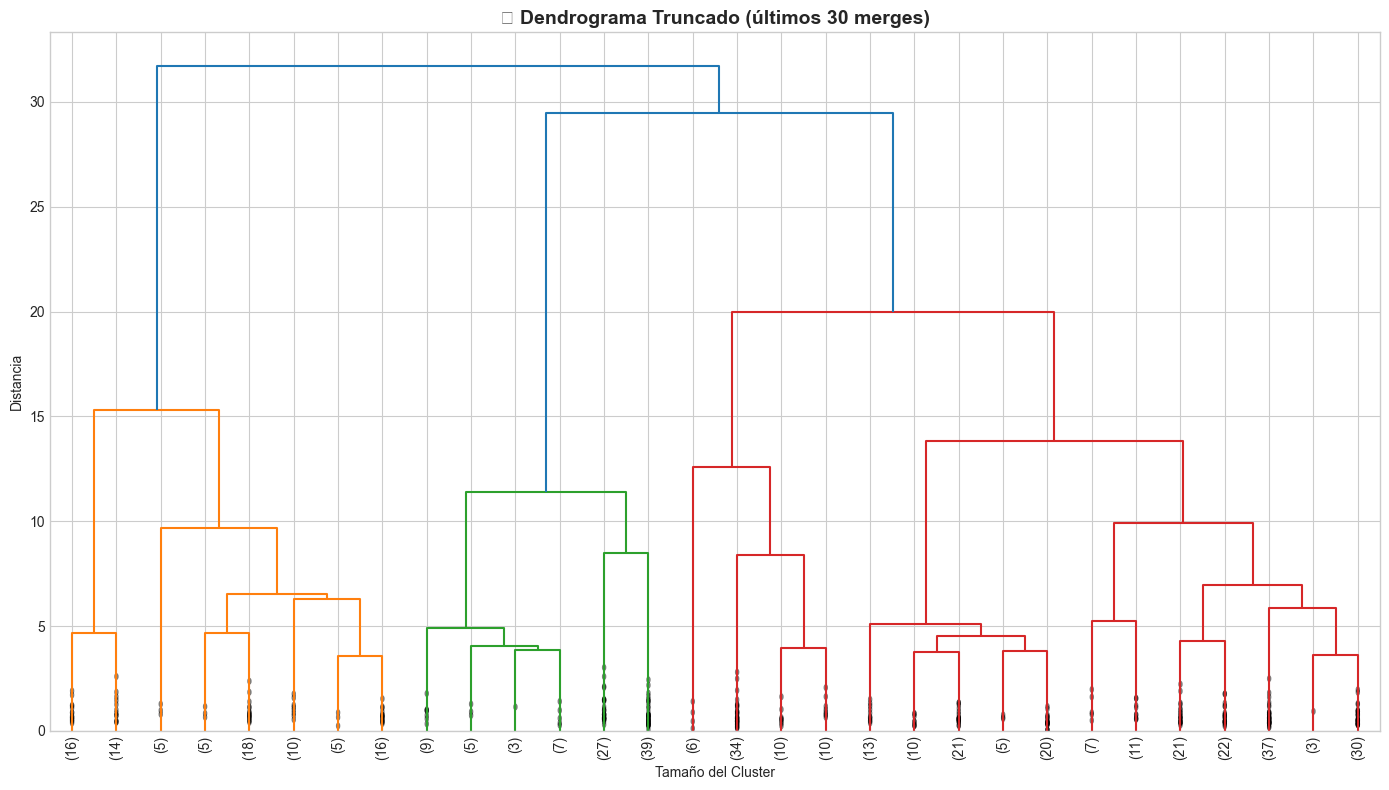

In [26]:
# ============================================
# DENDROGRAMA TRUNCADO (MEJOR VISUALIZACIÓN)
# ============================================
fig, ax = plt.subplots(figsize=(14, 8))

dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=30,  # Mostrar últimos 30 merges
    leaf_rotation=90,
    leaf_font_size=10,
    show_contracted=True,
    ax=ax
)

ax.set_title('🌳 Dendrograma Truncado (últimos 30 merges)', fontsize=14, fontweight='bold')
ax.set_xlabel('Tamaño del Cluster')
ax.set_ylabel('Distancia')

plt.tight_layout()
plt.savefig('../reports/figures/dendrogram_truncated.png', dpi=150, bbox_inches='tight')
plt.show()

In [27]:
# ============================================
# ASIGNAR CLUSTERS JERÁRQUICOS (solo normales)
# ============================================
hierarchical_labels = fcluster(linkage_matrix, K_FINAL, criterion='maxclust') - 1  # 0-indexed

# Agregar etiquetas al DataFrame de normales
df_normal['cluster_hierarchical'] = hierarchical_labels

# Métricas de Hierarchical
sil_hier = silhouette_score(X_scaled_normal, hierarchical_labels)
db_hier = davies_bouldin_score(X_scaled_normal, hierarchical_labels)
ch_hier = calinski_harabasz_score(X_scaled_normal, hierarchical_labels)

print("="*60)
print("🟠 HIERARCHICAL CLUSTERING (Ward) - sin outliers")
print("="*60)
print(f"   Activos clusterizados: {len(df_normal)}")
print(f"   Número de clusters: {K_FINAL}")
print(f"   Silhouette Score:   {sil_hier:.4f}")
print(f"   Davies-Bouldin:     {db_hier:.4f}")
print(f"   Calinski-Harabasz:  {ch_hier:.2f}")
print("\n📊 Distribución de clusters:")
print(df_normal['cluster_hierarchical'].value_counts().sort_index())

🟠 HIERARCHICAL CLUSTERING (Ward) - sin outliers
   Activos clusterizados: 439
   Número de clusters: 4
   Silhouette Score:   0.2317
   Davies-Bouldin:     1.2275
   Calinski-Harabasz:  164.15

📊 Distribución de clusters:
cluster_hierarchical
0     89
1     90
2     60
3    200
Name: count, dtype: int64


## 7. Consolidación: Combinar Outliers + Clusters

In [28]:
# ============================================
# COMBINAR OUTLIERS (Cluster -1) + ACTIVOS NORMALES
# ============================================
# Los outliers mantienen cluster -1
# Los activos normales tienen clusters 0 a K_FINAL-1

# Asignar cluster -1 a outliers para cada método
df_outliers['cluster_kmeans'] = -1
df_outliers['cluster_agglomerative'] = -1
df_outliers['cluster_hierarchical'] = -1

# Concatenar DataFrames
df_final = pd.concat([df_normal, df_outliers])

# Ordenar por índice para mantener consistencia
df_final = df_final.sort_index()

print("="*60)
print("📊 CONSOLIDACIÓN FINAL: OUTLIERS + CLUSTERS")
print("="*60)
print(f"\n🔴 Cluster -1 (Outliers):        {len(df_outliers)} activos")
print(f"🟢 Clusters 0 a {K_FINAL-1} (Normales): {len(df_normal)} activos")
print(f"📊 Total de activos:             {len(df_final)}")

print("\n📋 Distribución final (K-Means):")
print(df_final['cluster_kmeans'].value_counts().sort_index())

print("\n✅ Segmentación completada:")
print(f"   • Cluster -1: Activos de RIESGO EXTREMO (outliers)")
for i in range(K_FINAL):
    n = (df_final['cluster_kmeans'] == i).sum()
    print(f"   • Cluster {i}:  {n} activos")

📊 CONSOLIDACIÓN FINAL: OUTLIERS + CLUSTERS

🔴 Cluster -1 (Outliers):        29 activos
🟢 Clusters 0 a 3 (Normales): 439 activos
📊 Total de activos:             468

📋 Distribución final (K-Means):
cluster_kmeans
-1     29
 0     50
 1     96
 2     94
 3    199
Name: count, dtype: int64

✅ Segmentación completada:
   • Cluster -1: Activos de RIESGO EXTREMO (outliers)
   • Cluster 0:  50 activos
   • Cluster 1:  96 activos
   • Cluster 2:  94 activos
   • Cluster 3:  199 activos


In [29]:
# ============================================
# RESUMEN DE CARACTERÍSTICAS POR SEGMENTO
# ============================================
print("📊 CARACTERÍSTICAS PROMEDIO POR SEGMENTO (K-Means)")
print("="*70)

# Crear resumen incluyendo outliers
segment_summary = df_final.groupby('cluster_kmeans')[feature_cols].mean()

# Renombrar índice para claridad
segment_summary.index = [f'Cluster {i}' if i >= 0 else 'OUTLIERS (-1)' for i in segment_summary.index]

display(segment_summary.round(4))

📊 CARACTERÍSTICAS PROMEDIO POR SEGMENTO (K-Means)


,return_annualized,volatility_annual,sharpe_ratio,sortino_ratio,max_drawdown,var_95,cvar_95,beta,skewness,kurtosis
OUTLIERS (-1),-0.0884,0.5779,-0.0724,-0.0219,-0.6268,-0.0446,-0.0704,0.9180,0.6787,27.7129
Cluster 0,-0.0824,0.2280,-0.5521,-0.5439,-0.4319,-0.0224,-0.0323,0.5613,-0.0621,4.3045
Cluster 1,0.2311,0.3071,0.6596,0.6685,-0.3333,-0.0299,-0.0418,0.9801,0.0430,2.9833
Cluster 2,0.0043,0.3884,0.0575,0.0619,-0.5682,-0.0374,-0.0538,1.3021,-0.1517,4.7794
Cluster 3,0.0612,0.2366,0.1528,0.1504,-0.3264,-0.0232,-0.0335,0.7599,-0.1936,3.6137


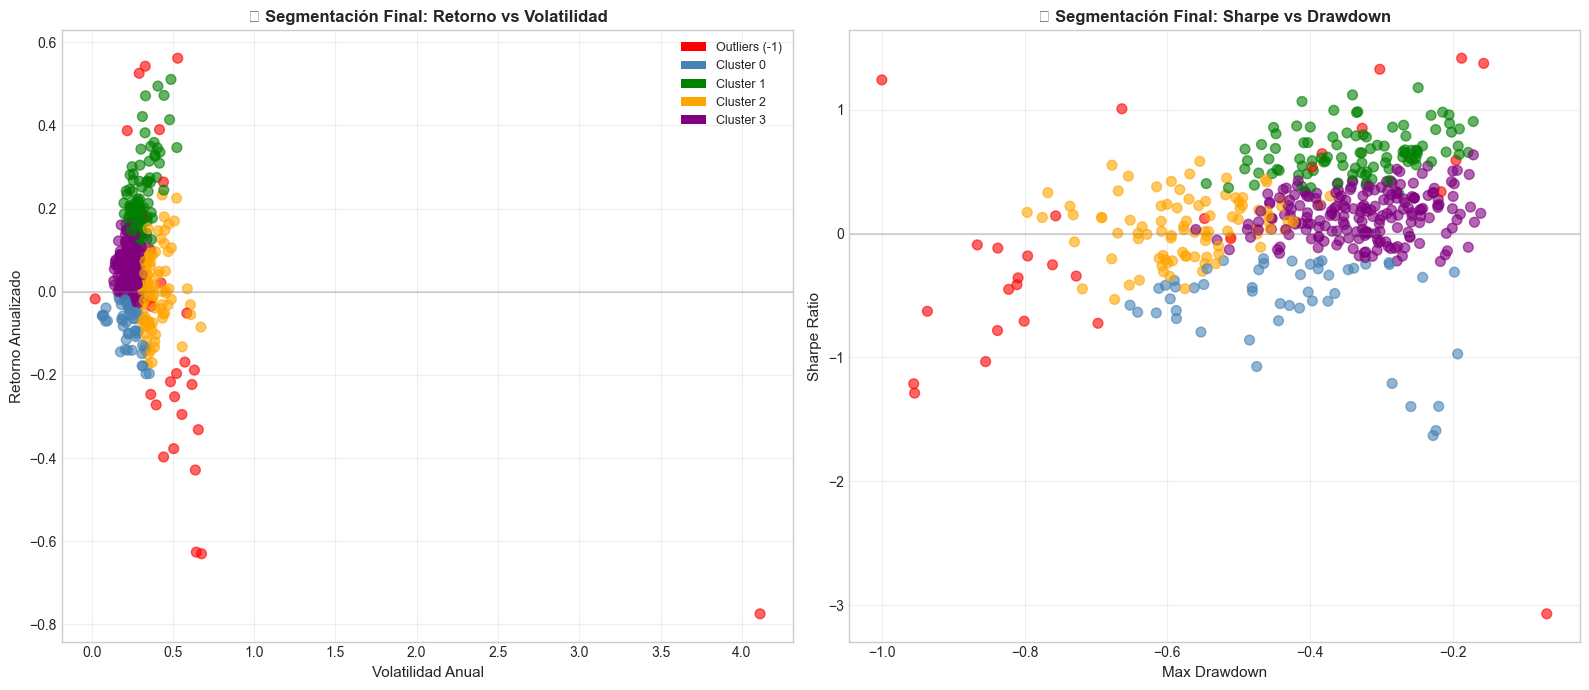


✅ Figura guardada en: ../reports/figures/segmentacion_final.png


In [30]:
# ============================================
# VISUALIZACIÓN DE SEGMENTACIÓN FINAL
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Colores para clusters (-1 = rojo, 0-4 = otros colores)
cluster_colors = {-1: 'red', 0: 'steelblue', 1: 'green', 2: 'orange', 3: 'purple', 4: 'brown'}
colors_final = [cluster_colors.get(c, 'gray') for c in df_final['cluster_kmeans']]

# Scatter plot: Return vs Volatility
ax1 = axes[0]
scatter1 = ax1.scatter(df_final['volatility_annual'], df_final['return_annualized'], 
                       c=colors_final, alpha=0.6, s=50)
ax1.set_xlabel('Volatilidad Anual', fontsize=11)
ax1.set_ylabel('Retorno Anualizado', fontsize=11)
ax1.set_title('📊 Segmentación Final: Retorno vs Volatilidad', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

# Scatter plot: Sharpe vs Max Drawdown
ax2 = axes[1]
scatter2 = ax2.scatter(df_final['max_drawdown'], df_final['sharpe_ratio'], 
                       c=colors_final, alpha=0.6, s=50)
ax2.set_xlabel('Max Drawdown', fontsize=11)
ax2.set_ylabel('Sharpe Ratio', fontsize=11)
ax2.set_title('📊 Segmentación Final: Sharpe vs Drawdown', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

# Leyenda
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', label='Outliers (-1)')]
for i in range(K_FINAL):
    legend_elements.append(Patch(facecolor=cluster_colors.get(i, 'gray'), label=f'Cluster {i}'))
ax1.legend(handles=legend_elements, loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('../reports/figures/segmentacion_final.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Figura guardada en: ../reports/figures/segmentacion_final.png")

## 8. Comparación de Métodos de Clustering

In [31]:
# ============================================
# TABLA COMPARATIVA DE MÉTRICAS
# ============================================
# NOTA: Las métricas se calcularon solo sobre activos normales (sin outliers)
comparison_data = {
    'Método': ['K-Means', 'Agglomerative', 'Hierarchical (Ward)'],
    'Silhouette ↑': [sil_kmeans, sil_agg, sil_hier],
    'Davies-Bouldin ↓': [db_kmeans, db_agg, db_hier],
    'Calinski-Harabasz ↑': [ch_kmeans, ch_agg, ch_hier]
}

df_comparison = pd.DataFrame(comparison_data)

print("📊 COMPARACIÓN DE MÉTODOS DE CLUSTERING")
print("="*70)
print(f"   (K = {K_FINAL} clusters sobre {len(df_normal)} activos normales)")
print(f"   (Outliers = {len(df_outliers)} activos en Cluster -1)")
print("   ↑ = Mayor es mejor  |  ↓ = Menor es mejor")
print("="*70)
df_comparison

📊 COMPARACIÓN DE MÉTODOS DE CLUSTERING
   (K = 4 clusters sobre 439 activos normales)
   (Outliers = 29 activos en Cluster -1)
   ↑ = Mayor es mejor  |  ↓ = Menor es mejor


,Método,Silhouette ↑,Davies-Bouldin ↓,Calinski-Harabasz ↑
0,K-Means,0.274829,1.111869,183.740714
1,Agglomerative,0.231655,1.227459,164.148732
2,Hierarchical (Ward),0.231655,1.227459,164.148732


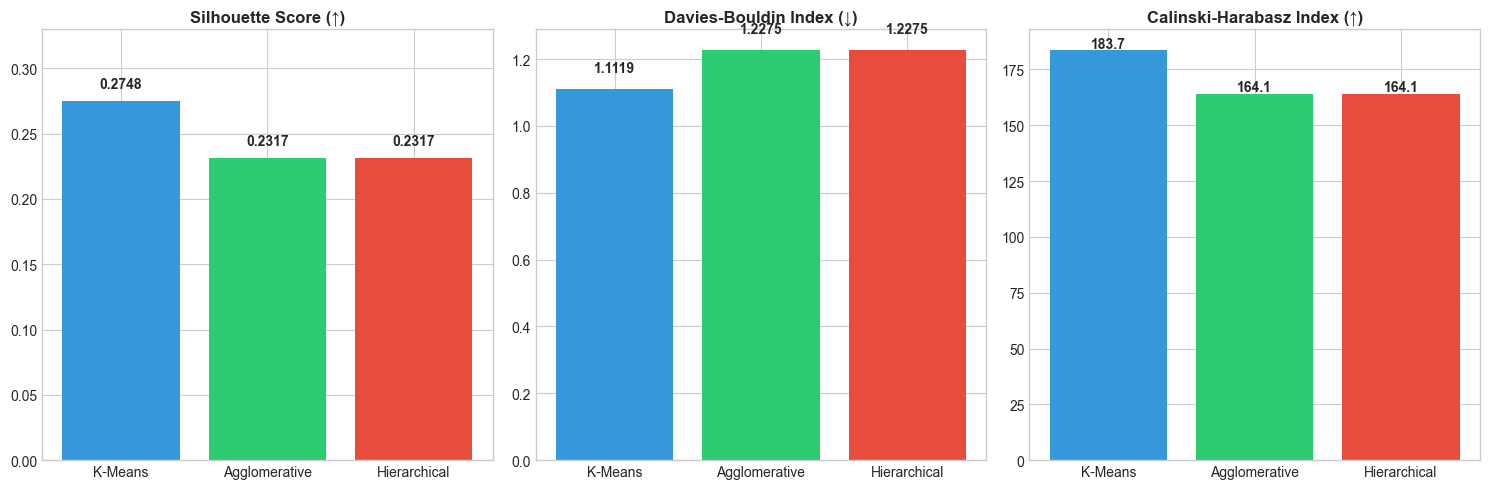

In [32]:
# ============================================
# VISUALIZACIÓN COMPARATIVA
# ============================================
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

methods = ['K-Means', 'Agglomerative', 'Hierarchical']
colors = ['#3498db', '#2ecc71', '#e74c3c']

# Silhouette
axes[0].bar(methods, [sil_kmeans, sil_agg, sil_hier], color=colors)
axes[0].set_title('Silhouette Score (↑)', fontweight='bold')
axes[0].set_ylim(0, max(sil_kmeans, sil_agg, sil_hier) * 1.2)
for i, v in enumerate([sil_kmeans, sil_agg, sil_hier]):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# Davies-Bouldin
axes[1].bar(methods, [db_kmeans, db_agg, db_hier], color=colors)
axes[1].set_title('Davies-Bouldin Index (↓)', fontweight='bold')
for i, v in enumerate([db_kmeans, db_agg, db_hier]):
    axes[1].text(i, v + 0.05, f'{v:.4f}', ha='center', fontweight='bold')

# Calinski-Harabasz
axes[2].bar(methods, [ch_kmeans, ch_agg, ch_hier], color=colors)
axes[2].set_title('Calinski-Harabasz Index (↑)', fontweight='bold')
for i, v in enumerate([ch_kmeans, ch_agg, ch_hier]):
    axes[2].text(i, v + 1, f'{v:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/clustering_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [33]:
# ============================================
# GUARDAR RESULTADOS FINALES
# ============================================
# Guardar DataFrame consolidado (outliers + clusters normales)
output_cols = feature_cols + ['cluster_kmeans', 'cluster_agglomerative', 'cluster_hierarchical', 'is_outlier_dbscan']

df_final[output_cols].to_csv('../reports/clustering_results.csv')

print("✅ RESULTADOS GUARDADOS")
print("="*60)
print("\n📁 Archivos generados:")
print("   • ../reports/clustering_results.csv")
print("   • ../reports/figures/cluster_metrics.png")
print("   • ../reports/figures/dendrogram_full.png")
print("   • ../reports/figures/dendrogram_truncated.png")
print("   • ../reports/figures/clustering_comparison.png")
print("   • ../reports/figures/dbscan_outliers.png")
print("   • ../reports/figures/segmentacion_final.png")

print(f"\n📊 RESUMEN DE SEGMENTACIÓN:")
print(f"   • Total activos: {len(df_final)}")
print(f"   • Outliers (Cluster -1): {len(df_outliers)} activos")
print(f"   • Clusters normales (0-{K_FINAL-1}): {len(df_normal)} activos")
print(f"   • Segmentos totales: {K_FINAL + 1} (incluyendo outliers)")

✅ RESULTADOS GUARDADOS

📁 Archivos generados:
   • ../reports/clustering_results.csv
   • ../reports/figures/cluster_metrics.png
   • ../reports/figures/dendrogram_full.png
   • ../reports/figures/dendrogram_truncated.png
   • ../reports/figures/clustering_comparison.png
   • ../reports/figures/dbscan_outliers.png
   • ../reports/figures/segmentacion_final.png

📊 RESUMEN DE SEGMENTACIÓN:
   • Total activos: 468
   • Outliers (Cluster -1): 29 activos
   • Clusters normales (0-3): 439 activos
   • Segmentos totales: 5 (incluyendo outliers)


## 📋 Resumen del Análisis de Clustering

### Metodología aplicada:
1. ✅ **Detección de outliers con DBSCAN** - 29 activos identificados como riesgo extremo
2. ✅ **Separación de datos** - Outliers mantenidos como Cluster -1
3. ✅ **Clustering solo sobre activos normales** (439 activos)
4. ✅ **K-Means, Agglomerative y Hierarchical** aplicados

### Segmentación final:
| Segmento | Descripción | Activos |
|----------|-------------|---------|
| **Cluster -1** | Outliers - Riesgo Extremo | 29 |
| **Clusters 0-3** | Activos normales segmentados | 439 |

### Ventajas de este enfoque:
- 🎯 Los outliers no distorsionan el clustering
- 📊 Métricas de clustering más fiables
- 💼 Segmentación más útil para gestión de portafolios
- ⚠️ Activos de riesgo extremo claramente identificados

### Próximos pasos (Parte 2):
- Visualización de clusters en 2D (PCA/t-SNE)
- Análisis de perfiles de clusters
- Interpretación financiera de cada segmento
- Selección del mejor método para portafolios

## 9. Exportación de Datos para Selección de Portafolio

In [34]:
# ============================================
# EXPORTACIÓN DE SEGMENTACIÓN FINAL (K-MEANS)
# ============================================
# Este archivo será el insumo para el notebook "04_seleccion_portafolio.ipynb"

import os

# Crear subcarpeta para segmentación final
output_dir = '../data/segmentacion_final'
os.makedirs(output_dir, exist_ok=True)

# ============================================
# 1. PREPARAR DATAFRAME FINAL CON K-MEANS
# ============================================
# Seleccionar solo las columnas relevantes para selección de portafolio

# Columnas de features
cols_features = feature_cols.copy()

# Agregar columna de segmento K-Means (renombrada para claridad)
df_export = df_final[cols_features].copy()
df_export['segmento'] = df_final['cluster_kmeans']

# ============================================
# ASIGNACIÓN DINÁMICA DE NOMBRES DE SEGMENTO
# ============================================
# IMPORTANTE: Los números de cluster en K-Means son ARBITRARIOS y pueden
# cambiar entre ejecuciones. Por ello, asignamos nombres basándonos en las
# CARACTERÍSTICAS REALES de cada cluster, no en el número.
#
# Criterios de clasificación:
#   - Alto_Rendimiento: Mayor Sharpe Ratio (mejor retorno ajustado por riesgo)
#   - Conservador: Menor Volatilidad (menor riesgo)
#   - Estable: Menor Max Drawdown (caídas menos severas)
#   - Moderado: El cluster restante (características intermedias)
# ============================================

# Calcular métricas promedio por cluster (solo clusters normales, excluyendo outliers)
cluster_means = df_export[df_export['segmento'] >= 0].groupby('segmento')[['sharpe_ratio', 'volatility_annual', 'max_drawdown']].mean()

print("📊 ASIGNACIÓN DINÁMICA DE NOMBRES DE SEGMENTO")
print("="*60)
print("\nMétricas promedio por cluster numérico:")
display(cluster_means.round(4))

# Identificar clusters por características
cluster_alto_rendimiento = cluster_means['sharpe_ratio'].idxmax()  # Mayor Sharpe
cluster_conservador = cluster_means['volatility_annual'].idxmin()   # Menor volatilidad
cluster_estable = cluster_means['max_drawdown'].idxmax()            # Menor drawdown (menos negativo = mayor valor)

# El cluster restante es "Moderado"
clusters_asignados = {cluster_alto_rendimiento, cluster_conservador, cluster_estable}
clusters_disponibles = set(cluster_means.index) - clusters_asignados

# Si hay conflictos (un cluster cumple múltiples criterios), resolver por prioridad
if len(clusters_disponibles) == 0:
    # Hay solapamiento - usar criterio de prioridad: Sharpe > Volatilidad > Drawdown
    # Resetear y asignar por orden de prioridad
    clusters_usados = set()
    
    # 1. Alto Rendimiento = Mayor Sharpe
    cluster_alto_rendimiento = cluster_means['sharpe_ratio'].idxmax()
    clusters_usados.add(cluster_alto_rendimiento)
    
    # 2. Conservador = Menor volatilidad (de los restantes)
    remaining = cluster_means.drop(index=list(clusters_usados))
    cluster_conservador = remaining['volatility_annual'].idxmin()
    clusters_usados.add(cluster_conservador)
    
    # 3. Estable = Menor drawdown (de los restantes)
    remaining = cluster_means.drop(index=list(clusters_usados))
    cluster_estable = remaining['max_drawdown'].idxmax()
    clusters_usados.add(cluster_estable)
    
    # 4. Moderado = el restante
    remaining = cluster_means.drop(index=list(clusters_usados))
    cluster_moderado = remaining.index[0] if len(remaining) > 0 else None
else:
    cluster_moderado = list(clusters_disponibles)[0] if clusters_disponibles else None

# Crear diccionario de mapeo dinámico
segmento_nombres = {-1: 'Outliers_Riesgo_Extremo'}
segmento_nombres[cluster_alto_rendimiento] = 'Alto_Rendimiento'
segmento_nombres[cluster_conservador] = 'Conservador'
segmento_nombres[cluster_estable] = 'Estable'
if cluster_moderado is not None:
    segmento_nombres[cluster_moderado] = 'Moderado'

# Mostrar asignación
print("\n✅ ASIGNACIÓN FINAL DE NOMBRES:")
print("-"*60)
print(f"   🔴 Cluster -1 → Outliers_Riesgo_Extremo (outliers detectados por DBSCAN)")
print(f"   🟢 Cluster {cluster_alto_rendimiento} → Alto_Rendimiento (mayor Sharpe: {cluster_means.loc[cluster_alto_rendimiento, 'sharpe_ratio']:.4f})")
print(f"   🔵 Cluster {cluster_conservador} → Conservador (menor volatilidad: {cluster_means.loc[cluster_conservador, 'volatility_annual']:.4f})")
print(f"   🟣 Cluster {cluster_estable} → Estable (menor drawdown: {cluster_means.loc[cluster_estable, 'max_drawdown']:.4f})")
if cluster_moderado is not None:
    print(f"   🟠 Cluster {cluster_moderado} → Moderado (características intermedias)")

df_export['segmento_nombre'] = df_export['segmento'].map(segmento_nombres)

# Agregar flag de outlier
df_export['is_outlier'] = df_export['segmento'] == -1

# ============================================
# 2. EXPORTAR ARCHIVOS
# ============================================

# 2.1 Base principal con todas las features y segmentación
file_main = os.path.join(output_dir, 'activos_segmentados_kmeans.csv')
df_export.to_csv(file_main)

# 2.2 Resumen de características por segmento
file_summary = os.path.join(output_dir, 'resumen_segmentos.csv')
summary_by_segment = df_export.groupby('segmento')[cols_features].agg(['mean', 'std', 'min', 'max'])
summary_by_segment.to_csv(file_summary)

# 2.3 Lista de tickers por segmento
file_tickers = os.path.join(output_dir, 'tickers_por_segmento.csv')
tickers_by_segment = df_export.reset_index().groupby('segmento')['ticker'].apply(list).to_frame()
tickers_by_segment['count'] = df_export.groupby('segmento').size()
tickers_by_segment.to_csv(file_tickers)

# 2.4 Metadata del modelo
file_metadata = os.path.join(output_dir, 'metadata_segmentacion.txt')
with open(file_metadata, 'w') as f:
    f.write("="*60 + "\n")
    f.write("METADATA DE SEGMENTACIÓN - K-MEANS CLUSTERING\n")
    f.write("="*60 + "\n\n")
    f.write(f"Fecha de generación: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Método seleccionado: K-Means (random_state=42)\n")
    f.write(f"Número de clusters (K): {K_FINAL}\n")
    f.write(f"Total de activos: {len(df_export)}\n")
    f.write(f"Activos normales: {(~df_export['is_outlier']).sum()}\n")
    f.write(f"Outliers (Cluster -1): {df_export['is_outlier'].sum()}\n\n")
    f.write("MÉTRICAS DE CLUSTERING:\n")
    f.write(f"  - Silhouette Score: {sil_kmeans:.4f}\n")
    f.write(f"  - Davies-Bouldin Index: {db_kmeans:.4f}\n")
    f.write(f"  - Calinski-Harabasz Index: {ch_kmeans:.2f}\n\n")
    f.write("ASIGNACIÓN DINÁMICA DE NOMBRES (basada en características):\n")
    f.write("  IMPORTANTE: Los nombres se asignan según métricas, NO por número de cluster.\n")
    f.write(f"  - Alto_Rendimiento: Cluster {cluster_alto_rendimiento} (mayor Sharpe Ratio)\n")
    f.write(f"  - Conservador: Cluster {cluster_conservador} (menor Volatilidad)\n")
    f.write(f"  - Estable: Cluster {cluster_estable} (menor Max Drawdown)\n")
    if cluster_moderado is not None:
        f.write(f"  - Moderado: Cluster {cluster_moderado} (características intermedias)\n")
    f.write("\nFEATURES UTILIZADAS:\n")
    for col in cols_features:
        f.write(f"  - {col}\n")
    f.write("\nDISTRIBUCIÓN POR SEGMENTO:\n")
    for seg in sorted(df_export['segmento'].unique()):
        count = (df_export['segmento'] == seg).sum()
        pct = 100 * count / len(df_export)
        nombre = segmento_nombres[seg]
        f.write(f"  - Segmento {seg} ({nombre}): {count} activos ({pct:.1f}%)\n")

# ============================================
# 3. MOSTRAR RESUMEN DE EXPORTACIÓN
# ============================================
print("="*70)
print("✅ EXPORTACIÓN COMPLETADA - SEGMENTACIÓN K-MEANS")
print("="*70)
print(f"\n📁 Carpeta de destino: {os.path.abspath(output_dir)}")
print("\n📄 Archivos generados:")
print(f"   1. activos_segmentados_kmeans.csv  ({len(df_export)} filas)")
print(f"      → Base principal con features + segmento asignado")
print(f"   2. resumen_segmentos.csv")
print(f"      → Estadísticas (mean, std, min, max) por segmento")
print(f"   3. tickers_por_segmento.csv")
print(f"      → Lista de tickers agrupados por segmento")
print(f"   4. metadata_segmentacion.txt")
print(f"      → Información del modelo y parámetros")

print("\n📊 RESUMEN DE SEGMENTACIÓN:")
print("-"*50)
# Usar colores basados en nombre, no en número de cluster
emoji_map = {
    'Outliers_Riesgo_Extremo': '🔴',
    'Alto_Rendimiento': '🟢',
    'Conservador': '🔵',
    'Estable': '🟣',
    'Moderado': '🟠'
}
for seg in sorted(df_export['segmento'].unique()):
    count = (df_export['segmento'] == seg).sum()
    pct = 100 * count / len(df_export)
    nombre = segmento_nombres[seg]
    emoji = emoji_map.get(nombre, '⚪')
    print(f"   {emoji} Segmento {seg:2d} ({nombre:25s}): {count:3d} activos ({pct:5.1f}%)")

print("\n" + "="*70)
print("🎯 PRÓXIMO PASO: Usar 'activos_segmentados_kmeans.csv'")
print("   en el notebook '04_seleccion_portafolio.ipynb'")
print("="*70)

📊 ASIGNACIÓN DINÁMICA DE NOMBRES DE SEGMENTO

Métricas promedio por cluster numérico:


,sharpe_ratio,volatility_annual,max_drawdown
segmento,,,
0,-0.5521,0.2280,-0.4319
1,0.6596,0.3071,-0.3333
2,0.0575,0.3884,-0.5682
3,0.1528,0.2366,-0.3264



✅ ASIGNACIÓN FINAL DE NOMBRES:
------------------------------------------------------------
   🔴 Cluster -1 → Outliers_Riesgo_Extremo (outliers detectados por DBSCAN)
   🟢 Cluster 1 → Alto_Rendimiento (mayor Sharpe: 0.6596)
   🔵 Cluster 0 → Conservador (menor volatilidad: 0.2280)
   🟣 Cluster 3 → Estable (menor drawdown: -0.3264)
   🟠 Cluster 2 → Moderado (características intermedias)
✅ EXPORTACIÓN COMPLETADA - SEGMENTACIÓN K-MEANS

📁 Carpeta de destino: c:\Users\carlo\Documents\4.DS\riskmanagement2025\data\segmentacion_final

📄 Archivos generados:
   1. activos_segmentados_kmeans.csv  (468 filas)
      → Base principal con features + segmento asignado
   2. resumen_segmentos.csv
      → Estadísticas (mean, std, min, max) por segmento
   3. tickers_por_segmento.csv
      → Lista de tickers agrupados por segmento
   4. metadata_segmentacion.txt
      → Información del modelo y parámetros

📊 RESUMEN DE SEGMENTACIÓN:
--------------------------------------------------
   🔴 Segmento -1 (Ou

In [35]:
# ============================================
# VISTA PREVIA DEL ARCHIVO EXPORTADO
# ============================================
print("📋 VISTA PREVIA: activos_segmentados_kmeans.csv")
print("="*70)
print(f"\nColumnas: {list(df_export.columns)}")
print(f"\nPrimeras 10 filas:")
display(df_export.head(10))

print(f"\n📊 Distribución de segmentos:")
display(df_export['segmento_nombre'].value_counts())

📋 VISTA PREVIA: activos_segmentados_kmeans.csv

Columnas: ['return_annualized', 'volatility_annual', 'sharpe_ratio', 'sortino_ratio', 'max_drawdown', 'var_95', 'cvar_95', 'beta', 'skewness', 'kurtosis', 'segmento', 'segmento_nombre', 'is_outlier']

Primeras 10 filas:


,return_annualized,volatility_annual,sharpe_ratio,sortino_ratio,max_drawdown,var_95,cvar_95,beta,skewness,kurtosis,segmento,segmento_nombre,is_outlier
ticker,,,,,,,,,,,,,
A,0.054633,0.282317,0.151784,0.153283,-0.435687,-0.029414,-0.037721,1.048419,0.239581,2.063034,3,Estable,False
AAL,-0.031805,0.469775,0.058819,0.061490,-0.577072,-0.044331,-0.062014,1.407044,0.193564,1.247544,2,Moderado,False
AAP,-0.272134,0.397305,-0.707455,-0.606561,-0.800546,-0.035611,-0.061724,0.911450,-4.070076,52.146478,-1,Outliers_Riesgo_Extremo,True
AAPL,0.142527,0.277969,0.437804,0.441195,-0.313115,-0.029794,-0.038538,1.263736,0.102541,1.734805,1,Alto_Rendimiento,False
ABBV,0.137979,0.208412,0.484830,0.440012,-0.242627,-0.019269,-0.032427,0.361027,-0.951209,4.925630,3,Estable,False
ABT,0.002942,0.227957,-0.092310,-0.089701,-0.362435,-0.022261,-0.032113,0.726030,-0.237728,4.174523,3,Estable,False
ACN,0.110896,0.256311,0.342872,0.340958,-0.407419,-0.026192,-0.036688,1.152408,0.058582,2.173147,3,Estable,False
ADBE,0.071678,0.360934,0.235854,0.221824,-0.600215,-0.034158,-0.054577,1.463840,-0.804391,5.665175,2,Moderado,False
ADI,0.108585,0.303931,0.326195,0.325740,-0.275794,-0.031145,-0.041168,1.281442,0.005717,1.140443,1,Alto_Rendimiento,False



📊 Distribución de segmentos:


segmento_nombre
Estable                    199
Alto_Rendimiento            96
Moderado                    94
Conservador                 50
Outliers_Riesgo_Extremo     29
Name: count, dtype: int64